**Capsule Networks (CapsNets)**

*Based on the paper: [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829), by Sara Sabour, Nicholas Frosst and Geoffrey E. Hinton (NIPS 2017).*

Adapted from https://colab.research.google.com/github/ageron/handson-ml/blob/master/extra_capsnets.ipynb.



*Inspired in part from Huadong Liao's implementation: [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow).*

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml/blob/master/extra_capsnets.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Introduction

Watch [this video](https://youtu.be/pPN8d0E3900) to understand the key ideas behind Capsule Networks:

In [ ]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/pPN8d0E3900", width=560, height=315, frameborder=0, allowfullscreen=True)

# Imports

Install numpy version 1.19 **and** restart the runtime. Numpy 1.21 cannot work with symbolic tensors.

In [1]:
!pip install numpy==1.19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To support both Python 2 and Python 3:

In [2]:
from __future__ import division, print_function, unicode_literals

To plot pretty figures:

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

We will need NumPy and TensorFlow:

In [4]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 1.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


Just shortly check here that numpy 1.19 is actually the running version.

In [5]:
np.version.version

'1.19.0'

In [6]:
%load_ext tensorboard
import datetime
from google.colab import drive
import os

drive.mount('/content/drive')
%cd '/content/drive/My Drive/CapsNets'
log_dir = "/content/drive/My Drive/CapsNets/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
os.makedirs(log_dir, exist_ok=True)
#%tensorboard --port=6008 --logdir {log_dir}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CapsNets


# Reproducibility

Let's reset the default graph, in case you re-run this notebook without restarting the kernel:

In [7]:
tf.reset_default_graph()

Let's set the random seeds so that this notebook always produces the same output:

In [8]:
np.random.seed(42)
tf.set_random_seed(42)

This network can also be run with MNIST instead of EMNIST. Outcomment this code for that purpose.

In [9]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/")
#fashion_mnist = input_data.read_data_sets('tmp/data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')
#sample = mnist.train.images[5].reshape(28, 28)
#plt.imshow(sample, cmap="binary")

If SVHN is ought to be used for training, then this code sample needs to be outcommented and run.

In [10]:
##sample = svhn.train.images[5].reshape(32,32)
#(svhn_train, svhn_test), info = tfds.load('svhn_cropped', split=['train', 'test'],
#                                      with_info=True, shuffle_files=True,
#                                      as_supervised=True)
#TRAIN_SIZE = 60000

#dataset, info = tfds.load("svhn_cropped", batch_size=-1, with_info=True)
#print(info)
#svhn_train, svhn_test = dataset["train"], dataset["test"]
#print(type(svhn_train['image']))

#x_train = svhn_train['image']
#y_train = svhn_train['label']

#x_test = svhn_test['image']
#y_test = svhn_test['label']


#x_train = tfds.as_numpy(x_train)
#x_test = tfds.as_numpy(x_test)

#y_train = tfds.as_numpy(y_train)
#y_test = tfds.as_numpy(y_test)

#x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
#x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

#y_train = tf.keras.utils.to_categorical(y_train.astype('float32'))
#y_test = tf.keras.utils.to_categorical(y_test.astype('float32'))

#x_train, x_validation = x_train[:TRAIN_SIZE], x_train[TRAIN_SIZE:]
#y_train, y_validation = y_train[:TRAIN_SIZE], y_train[TRAIN_SIZE:]
#print(type(svhn_train['image']))
#print(svhn_train['image'].shape)
#print(svhn_train['label'].shape)

#svhn = svhn.as_dataset()
#train_svhn, test_svhn = svhn['train'], svhn['test']

#svhn_train = svhn["train"]
#sample = svhn_train[2].reshape(32,32)
#plt.imshow(sample, cmap= 'binary')

#np_svhn = tfds.as_numpy(svhn_train)

#def normalize_img(image, label):
#    """Normalizes images: `uint8` -> `float32`."""
#    return tf.cast(image, tf.float32) / 255., label

#print(svhn_train)
#train_svhn = svhn_train.map(
#   normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#svhn_train = svhn_train.cache()  # fit faster
#svhn_train = svhn_train.batch(128)  # batch-size
#svhn_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
#print(train_svhn)
#test_svhn = svhn_test.map(
#    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Load EMNIST/letters

This code only needs to be run once. Afterwards, the test, validation and training data will be saved and you can start at "Loading Saved EMNIST".

In [ ]:
!pip install tensorflow_datasets==3.2.1

     |████████████████████████████████| 3.4 MB 8.7 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [ ]:
import tensorflow_datasets as tfds
#emnist = tfds.load("emnist/letters")
#emnist = tfds.load("emnist/byclass")
#svhn = tfds.load("svhn_cropped")

Split data set into test and train. Transform data so that it is usable in similar manner as MNIST.

In [ ]:
#this code for emnist - emnist is also a 28*28 data set but with 37 classes
#TRAIN_SIZE = 60000

#dataset, info = tfds.load("emnist/letters", batch_size=-1, with_info=True)
#dataset = tfds.load("emnist/byclass", batch_size=-1, with_info=True)
#print(info)
#emnist_train, emnist_test = dataset["train"], dataset["test"]
emnist_train = tfds.load(name="emnist/byclass", split=tfds.Split.TRAIN, batch_size=-1 ) 
emnist_test = tfds.load(name="emnist/byclass", split=tfds.Split.TEST, batch_size=-1)

print(type(emnist_train['image']))

x_train = emnist_train['image']
y_train = emnist_train['label']

x_test = emnist_test['image']
y_test = emnist_test['label']

#translate everything into numpy for usage
x_train = tfds.as_numpy(x_train)
y_train = tfds.as_numpy(y_train)

x_test = tfds.as_numpy(x_test)
y_test = tfds.as_numpy(y_test)

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

y_train = tf.keras.utils.to_categorical(y_train.astype('float32'))
y_test = tf.keras.utils.to_categorical(y_test.astype('float32'))

#x_train, x_validation = x_train[:TRAIN_SIZE], x_train[TRAIN_SIZE:]
#y_train, y_validation = y_train[:TRAIN_SIZE], y_train[TRAIN_SIZE:]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/emnist/byclass/3.0.0.incomplete7CSI7B/emnist-train.tfrecord


  0%|          | 0/697932 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/emnist/byclass/3.0.0.incomplete7CSI7B/emnist-test.tfrecord


  0%|          | 0/116323 [00:00<?, ? examples/s]

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.0.0. Subsequent calls will reuse this data.


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'
<class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
TRAIN_SIZE = int(x_train.shape[0]*0.75)

x_train, x_validation = x_train[:TRAIN_SIZE], x_train[TRAIN_SIZE:]
y_train, y_validation = y_train[:TRAIN_SIZE], y_train[TRAIN_SIZE:]

In [ ]:
#sample = svhn_train['image'][7]
#label = svhn_test['label'][7]
#plt.imshow(sample, cmap = 'binary')
#sample.shape
#print(label)

Because EMNIST is somehow rotated and flipped when imported, data is put in normal position with the help of this code segment.

In [ ]:
#size = (-1,32,32,3)
#pixel= 32
size = (-1,28,28,1)
pixel = 28 
def shape_normal(set_of_pictures):
  set_of_pictures_r = set_of_pictures.reshape(size)
  set_of_pictures_r2 = set_of_pictures_r
  for index in range(np.shape(set_of_pictures_r)[0]):
    sample_image = set_of_pictures_r[index].reshape(28,28)
    sample_image = np.rot90(sample_image,1,(0,1))
    sample_image = np.flipud(sample_image)
    set_of_pictures_r2[index] = sample_image.reshape(28,28,1)
  return set_of_pictures_r2

x_train_r2 = shape_normal(x_train)
x_test_r2 = shape_normal(x_test)
x_validation_r2 = shape_normal(x_validation)

In [ ]:
np.shape(x_train_r2)

(523449, 28, 28, 1)

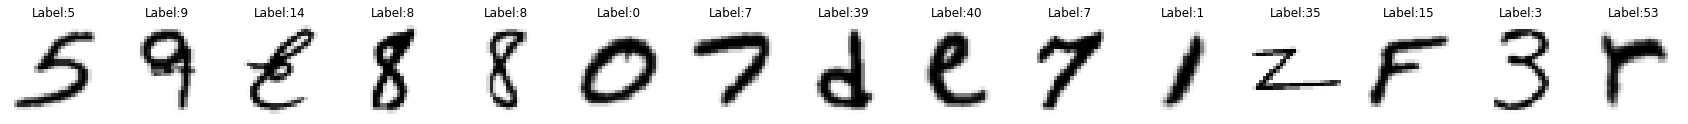

In [ ]:
n_samples = 15

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    #sample_image = mnist.train.images[index].reshape(28, 28)
    sample_image = x_train[index].reshape(28,28)
    #sample_image = np.rot90(sample_image, 1, (0,1))
    #sample_image = np.flipud(sample_image)
    plt.title("Label:" + str(np.argmax(y_train[index])))
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

And these are the corresponding labels:

In [ ]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


As seen y_train is one-hot encoded. Therefore argmax is needed to transform arrays for each item into numbers.

In [ ]:
#mnist.train.labels[:n_samples]
#svhn_train['label'][:n_samples]
y_train = np.argmax(y_train, axis=1)
y_validation = np.argmax(y_validation, axis=1)
y_test = np.argmax(y_test, axis=1)

Since we want to only use C, H, S, T, we are going to extract first the indices and then with these
 the letter pictures from the whole range of letters.

In [ ]:
import random 

#letters_of_interest = (3,8,18,19)
letters_of_interest = (12,17,28,29) # only uppercase letters
#letters_of_interest =(0,1,2,3)

count_test = [0]*4
count_train = [0]*4
count_validation = [0]*4
letter_len = [0]*4

for letter in range(len(letters_of_interest)):
  index_test_len = [i for i,x in enumerate(y_test) if x == letters_of_interest[letter]]
  count_test[letter] = len(index_test_len)
  index_train_len = [i for i,x in enumerate(y_train) if x == letters_of_interest[letter]]
  count_train[letter] = len(index_train_len)
  index_validation_len = [i for i,x in enumerate(y_validation) if x == letters_of_interest[letter]]
  count_validation[letter] = len(index_validation_len)

for letter in range(len(letters_of_interest)):
  letter_len[letter] = count_test[letter] + count_train[letter] + count_validation[letter]

len_min = min(letter_len)
len_train = int(len_min * 0.8)
len_validation = int((len_min-len_train)*0.1)
len_test = len_min - len_train - len_validation

x_long = np.concatenate((x_test_r2, x_train_r2, x_validation_r2))
y_long = np.concatenate((y_test, y_train, y_validation))

list_0 = np.empty(shape=(0,28,28,1))
list_1 = np.empty(shape=(0,28,28,1))
list_2 = np.empty(shape=(0,28,28,1))
list_3 = np.empty(shape=(0,28,28,1))

for item in range(len(y_long)):
  if y_long[item] == letters_of_interest[0]:
    list_0 = np.append(list_0, [x_long[item]], axis = 0)
    #list_0 = , decoder_output_long[item]], axis = 0)
  elif y_long[item] == letters_of_interest[1]:
    list_1 = np.append(list_1, [x_long[item]], axis = 0)
    #list_1 = np.append(list_1, [sample_images_long[item], decoder_output_long[item]], axis = 0)
  elif y_long[item] == letters_of_interest[2]:
    list_2 = np.append(list_2, [x_long[item]], axis = 0)
  elif y_long[item] == letters_of_interest[3]:
    list_3 = np.append(list_3, [x_long[item]], axis = 0)

x_train_new = np.concatenate((list_0[:len_train], list_1[:len_train],list_2[:len_train], list_3[:len_train]))
y_train_new = np.concatenate((np.array([letters_of_interest[0]]*len_train), np.array([letters_of_interest[1]]*len_train), np.array([letters_of_interest[2]]*len_train), np.array([letters_of_interest[3]]*len_train)))

x_validation_new = np.concatenate((list_0[len_train:(len_train + len_validation)], list_1[len_train:(len_train + len_validation)],list_2[len_train:(len_train + len_validation)], list_3[len_train:(len_train+len_validation)]))
y_validation_new = np.concatenate(([letters_of_interest[0]]*len_validation, [letters_of_interest[1]]*len_validation, [letters_of_interest[2]]*len_validation, [letters_of_interest[3]]*len_validation))

x_test_new = np.concatenate((list_0[(len_train+len_validation):(len_train+len_validation+len_test)], list_1[(len_train+len_validation):(len_train+len_validation+len_test)], list_2[(len_train + len_validation):(len_train+len_validation+len_test)], list_3[(len_train+len_validation):(len_train+len_validation+len_test)]))
y_test_new = np.concatenate(([letters_of_interest[0]]*len_test, [letters_of_interest[1]]*len_test, [letters_of_interest[2]]*len_test, [letters_of_interest[3]]*len_test))


#def shorter_index_list(letters_of_interest, y, length):
#  index_list = []
#  for letter in range(len(letters_of_interest)):
#    count = 0
#    for (i, x) in enumerate(y):
#      if x == letters_of_interest[letter] and count < length:
#        index_list.insert(-1, i)
#        count = count+1
#  return(index_list)

#index_train = shorter_index_list(letters_of_interest, y_long, len_train)

Now the extracted stimuli are saved in these numpy arrays, so that the whole process does not have to be run every time.

In [ ]:
np.savetxt('x_train_new.txt', x_train_new.reshape([-1,28*28]))
np.savetxt('x_test_new.txt.', x_test_new.reshape([-1,28*28]))
np.savetxt('x_validation_new.txt', x_validation_new.reshape([-1,28*28]))
np.savetxt('y_train_new.txt', y_train_new)
np.savetxt('y_validation_new.txt', y_validation_new)
np.savetxt('y_test_new.txt', y_test_new)

## Loading Saved EMNIST



In [129]:
x_train_new = np.loadtxt('x_train_new.txt')
x_test_new = np.loadtxt('x_test_new.txt')
x_validation_new = np.loadtxt('x_validation_new.txt')
y_train_new = np.loadtxt('y_train_new.txt')
y_test_new = np.loadtxt('y_test_new.txt')
y_validation_new = np.loadtxt('y_validation_new.txt')

Count how often each letter is in a specific data set to check that the data set is balanced.

In [12]:
letters_of_interest = (12,17,28,29)
c = 0
h = 0
s = 0
t = 0
for item in y_validation_new:
  if item == letters_of_interest[0]:
    c = c+1
  elif item == letters_of_interest[1]:
    h = h+1
  elif item == letters_of_interest[2]:
    s = s+1
  elif item == letters_of_interest[3]:
    t = t+1
print(c, h, s, t)
print(min([c,h,s,t]))

min_train = min([c,h,s,t])

73 73 73 73
73


# Load Own Letters

Read in letters that are coming from the study itself, adapt so that different positions, sizes given.

In [13]:
#%load_ext tensorboard
import datetime
from google.colab import drive
import os

drive.mount('/content/drive')
%cd '/content/drive/My Drive/CapsNets'
per_dir = "/content/drive/My Drive/CapsNets/Presented stimuli/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CapsNets


In [14]:
im_h = plt.imread(f'{per_dir}/letH.png')
im_s = plt.imread(f'{per_dir}/letS.png')
im_t = plt.imread(f'{per_dir}/letT.png')
im_c = plt.imread(f'{per_dir}/letC.png')

(870, 870, 4)

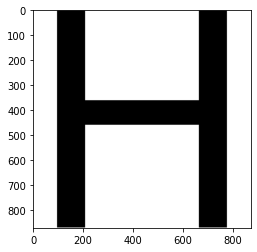

In [15]:
plt.imshow(im_h[:,:,0], cmap="binary")
im_h.shape

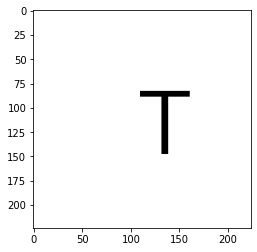

In [16]:
from PIL import Image, ImageDraw, ImageFilter
pictures = [im_c, im_h, im_s, im_t]
y_pics = [0, 1, 2, 3]
letter_array = np.empty((0,224,224))
empty_template = np.zeros((224,224))
PIL_empty = Image.fromarray(np.uint8(empty_template))

for variable in range(len(pictures)):
  sample = pictures[variable][:,:,0]
  P = Image.fromarray(sample)
  P = P.resize((67,67), resample = Image.BILINEAR)
  back_im = PIL_empty.copy()
  back_im.paste(P, (102,82))
  P = np.array(back_im)
  P = np.array(P)
  letter_array = np.append(letter_array, P.reshape(1,224,224), axis = 0)
  

np.shape(letter_array)
plt.imshow(letter_array[3,:,:], cmap="binary")

# Build CapsNet

Now let's build a Capsule Network to classify these images. Here's the overall architecture.
Note: for readability, I left out two arrows: Labels → Mask, and Input Images → Reconstruction Loss.
This part only depicts the CapsNet but before the Primary Capsules, an additional set of two layers from the CorNetZ are added. They consist of a convolutional layer and a pooling layer respectively.

```
                            Loss
                              ↑
                    ┌─────────┴─────────┐
      Labels → Margin Loss      Reconstruction Loss
                    ↑                   ↑
                  Length             Decoder
                    ↑                   ↑ 
             Digit Capsules ────Mask────┘
               ↖↑↗ ↖↑↗ ↖↑↗
             Primary Capsules
                    ↑      
               Input Images
```

We are going to build the graph starting from the bottom layer, and gradually move up, left side first. Let's go!

# Input Images

Let's start by creating a placeholder for the input images (28×28 pixels, 1 color channel = grayscale).

In [17]:
#X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
X = tf.placeholder(shape=[None, 224, 224, 1], dtype=tf.float32, name="X") #here 1 instead of 3 for EMNIST

# CorNet layers and Primary Capsules

The first layer will be composed of 32 maps of 6×6 capsules each, where each capsule will output an 8D activation vector:

In [18]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

To compute their outputs, we first apply two regular convolutional layers:

Implement V1 and V2 from CorNetZ (source: https://github.com/dicarlolab/CORnet/blob/master/cornet/cornet_z.py).

In [19]:
#tf.reset_default_graph()

In [20]:
conv_v1_params = {
    "filters": 64,
    "kernel_size": 7,
    "strides": 2,
    "padding": "same",
    "activation": tf.nn.relu,
}

conv_v2_params = {
    "filters": 128,
    "kernel_size": 3,
    "strides": 1,
    "padding": "same",
    "activation": tf.nn.relu,
}

In [21]:
#V1 specs
conv_v1 = tf.layers.conv2d(X, name="conv_v1", **conv_v1_params)
pool_v1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
   strides=(2, 2), padding='same', name = "pool_v1")(conv_v1)

#V2 specs
conv_v2 = tf.layers.conv2d(pool_v1, name = "conv_v2", **conv_v2_params)
pool_v2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
   strides=(2, 2), padding='same', name = "pool_v2")(conv_v2)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [22]:
print(conv_v1)
print(pool_v1)
print(conv_v2)
print(pool_v2)

Tensor("conv_v1/Relu:0", shape=(?, 112, 112, 64), dtype=float32)
Tensor("pool_v1/MaxPool:0", shape=(?, 56, 56, 64), dtype=float32)
Tensor("conv_v2/Relu:0", shape=(?, 56, 56, 128), dtype=float32)
Tensor("pool_v2/MaxPool:0", shape=(?, 28, 28, 128), dtype=float32)


In [23]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [24]:
conv1 = tf.layers.conv2d(pool_v2, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

In [25]:
print(conv1)
print(conv2)

Tensor("conv1/Relu:0", shape=(?, 20, 20, 256), dtype=float32)
Tensor("conv2/Relu:0", shape=(?, 6, 6, 256), dtype=float32)


Note: since we used a kernel size of 9 and no padding (for some reason, that's what `"valid"` means), the image shrunk by 9-1=8 pixels after each convolutional layer (28×28 to 20×20, then 20×20 to 12×12), and since we used a stride of 2 in the second convolutional layer, the image size was divided by 2. This is how we end up with 6×6 feature maps.

Next, we reshape the output to get a bunch of 8D vectors representing the outputs of the primary capsules. The output of `conv2` is an array containing 32×8=256 feature maps for each instance, where each feature map is 6×6. So the shape of this output is (_batch size_, 6, 6, 256). We want to chop the 256 into 32 vectors of 8 dimensions each. We could do this by reshaping to (_batch size_, 6, 6, 32, 8). However, since this first capsule layer will be fully connected to the next capsule layer, we can simply flatten the 6×6 grids. This means we just need to reshape to (_batch size_, 6×6×32, 8).

In [26]:
conv2

<tf.Tensor 'conv2/Relu:0' shape=(?, 6, 6, 256) dtype=float32>

In [27]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")
caps1_raw

<tf.Tensor 'caps1_raw:0' shape=(?, 1152, 8) dtype=float32>

Now we need to squash these vectors. Let's define the `squash()` function, based on equation (1) from the paper:

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

The `squash()` function will squash all vectors in the given array, along the given axis (by default, the last axis).

**Caution**, a nasty bug is waiting to bite you: the derivative of $\|\mathbf{s}\|$ is undefined when $\|\mathbf{s}\|=0$, so we can't just use `tf.norm()`, or else it will blow up during training: if a vector is zero, the gradients will be `nan`, so when the optimizer updates the variables, they will also become `nan`, and from then on you will be stuck in `nan` land. The solution is to implement the norm manually by computing the square root of the sum of squares plus a tiny epsilon value: $\|\mathbf{s}\| \approx \sqrt{\sum\limits_i{{s_i}^2}\,\,+ \epsilon}$.

The unsquash function turns around the respective calculation and gives out the positive value that would relate to the squashed value (this is needed for the decoder).

In [28]:
def squash(s, axis=-1, epsilon=1e-9, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

def unsquash(s, axis = -1, epsilon = 1e-9, name = None):
  with tf.name_scope(name, default_name="unsquash"):
    squared_norm = tf.reduce_sum(tf.square(s), axis= axis, keep_dims = True)
    safe_norm = tf.sqrt(squared_norm + epsilon)
    squash_factor = tf.sqrt(safe_norm/(1. - safe_norm))
    unit_vector = s/safe_norm
    return squash_factor*unit_vector

In [29]:
caps1_raw

<tf.Tensor 'caps1_raw:0' shape=(?, 1152, 8) dtype=float32>

Now let's apply this function to get the output $\mathbf{u}_i$ of each primary capsules $i$ :

In [30]:
caps1_output = squash(caps1_raw, name="caps1_output")
caps1_output

Instructions for updating:
keep_dims is deprecated, use keepdims instead


<tf.Tensor 'caps1_output/mul:0' shape=(?, 1152, 8) dtype=float32>

Great! We have the output of the first capsule layer. It wasn't too hard, was it? However, computing the next layer is where the fun really begins.

# Digit Capsules

To compute the output of the digit capsules, we must first compute the predicted output vectors (one for each primary / digit capsule pair). Then we can run the routing by agreement algorithm.

## Compute the Predicted Output Vectors

The digit capsule layer contains 10 capsules (one for each digit) of 16 dimensions each:

In [31]:
caps2_n_caps = 4
#caps2_n_caps = 37
caps2_n_dims = 16

For each capsule $i$ in the first layer, we want to predict the output of every capsule $j$ in the second layer. For this, we will need a transformation matrix $\mathbf{W}_{i,j}$ (one for each pair of capsules ($i$, $j$)), then we can compute the predicted output $\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$ (equation (2)-right in the paper). Since we want to transform an 8D vector into a 16D vector, each transformation matrix $\mathbf{W}_{i,j}$ must have a shape of (16, 8).

To compute $\hat{\mathbf{u}}_{j|i}$ for every pair of capsules ($i$, $j$), we will use a nice feature of the `tf.matmul()` function: you probably know that it lets you multiply two matrices, but you may not know that it also lets you multiply higher dimensional arrays. It treats the arrays as arrays of matrices, and it performs itemwise matrix multiplication. For example, suppose you have two 4D arrays, each containing a 2×3 grid of matrices. The first contains matrices $\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}, \mathbf{E}, \mathbf{F}$ and the second contains matrices $\mathbf{G}, \mathbf{H}, \mathbf{I}, \mathbf{J}, \mathbf{K}, \mathbf{L}$. If you multiply these two 4D arrays using the `tf.matmul()` function, this is what you get:

$
\pmatrix{
\mathbf{A} & \mathbf{B} & \mathbf{C} \\
\mathbf{D} & \mathbf{E} & \mathbf{F}
} \times
\pmatrix{
\mathbf{G} & \mathbf{H} & \mathbf{I} \\
\mathbf{J} & \mathbf{K} & \mathbf{L}
} = \pmatrix{
\mathbf{AG} & \mathbf{BH} & \mathbf{CI} \\
\mathbf{DJ} & \mathbf{EK} & \mathbf{FL}
}
$

We can apply this function to compute $\hat{\mathbf{u}}_{j|i}$ for every pair of capsules ($i$, $j$) like this (recall that there are 6×6×32=1152 capsules in the first layer, and 10 in the second layer):

$
\pmatrix{
  \mathbf{W}_{1,1} & \mathbf{W}_{1,2} & \cdots & \mathbf{W}_{1,10} \\
  \mathbf{W}_{2,1} & \mathbf{W}_{2,2} & \cdots & \mathbf{W}_{2,10} \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{W}_{1152,1} & \mathbf{W}_{1152,2} & \cdots & \mathbf{W}_{1152,10}
} \times
\pmatrix{
  \mathbf{u}_1 & \mathbf{u}_1 & \cdots & \mathbf{u}_1 \\
  \mathbf{u}_2 & \mathbf{u}_2 & \cdots & \mathbf{u}_2 \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{u}_{1152} & \mathbf{u}_{1152} & \cdots & \mathbf{u}_{1152}
}
=
\pmatrix{
\hat{\mathbf{u}}_{1|1} & \hat{\mathbf{u}}_{2|1} & \cdots & \hat{\mathbf{u}}_{10|1} \\
\hat{\mathbf{u}}_{1|2} & \hat{\mathbf{u}}_{2|2} & \cdots & \hat{\mathbf{u}}_{10|2} \\
\vdots & \vdots & \ddots & \vdots \\
\hat{\mathbf{u}}_{1|1152} & \hat{\mathbf{u}}_{2|1152} & \cdots & \hat{\mathbf{u}}_{10|1152}
}
$


The shape of the first array is (1152, 10, 16, 8), and the shape of the second array is (1152, 10, 8, 1). Note that the second array must contain 10 identical copies of the vectors $\mathbf{u}_1$ to $\mathbf{u}_{1152}$. To create this array, we will use the handy `tf.tile()` function, which lets you create an array containing many copies of a base array, tiled in any way you want.

Oh, wait a second! We forgot one dimension: _batch size_. Say we feed 50 images to the capsule network, it will make predictions for these 50 images simultaneously. So the shape of the first array must be (50, 1152, 10, 16, 8), and the shape of the second array must be (50, 1152, 10, 8, 1). The first layer capsules actually already output predictions for all 50 images, so the second array will be fine, but for the first array, we will need to use `tf.tile()` to have 50 copies of the transformation matrices.

Okay, let's start by creating a trainable variable of shape (1, 1152, 10, 16, 8) that will hold all the transformation matrices. The first dimension of size 1 will make this array easy to tile. We initialize this variable randomly using a normal distribution with a standard deviation to 0.1.

In [32]:
init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

W_init

<tf.Tensor 'W_init:0' shape=(1, 1152, 4, 16, 8) dtype=float32>

Now we can create the first array by repeating `W` once per instance:

In [33]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

That's it! On to the second array, now. As discussed earlier, we need to create an array of shape (_batch size_, 1152, 10, 8, 1), containing the output of the first layer capsules, repeated 10 times (once per digit, along the third dimension, which is axis=2). The `caps1_output` array has a shape of (_batch size_, 1152, 8), so we first need to expand it twice, to get an array of shape (_batch size_, 1152, 1, 8, 1), then we can repeat it 10 times along the third dimension:

In [34]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

Let's check the shape of the first array:

In [35]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 4, 16, 8) dtype=float32>

Good, and now the second:

In [36]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 4, 8, 1) dtype=float32>

Yes! Now, to get all the predicted output vectors $\hat{\mathbf{u}}_{j|i}$, we just need to multiply these two arrays using `tf.matmul()`, as explained earlier: 

In [37]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

Let's check the shape:

In [38]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 4, 16, 1) dtype=float32>

Perfect, for each instance in the batch (we don't know the batch size yet, hence the "?") and for each pair of first and second layer capsules (1152×10) we have a 16D predicted output column vector (16×1). We're ready to apply the routing by agreement algorithm!

## Routing by agreement

First let's initialize the raw routing weights $b_{i,j}$ to zero:

In [39]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

We will see why we need the last two dimensions of size 1 in a minute.

In [40]:
print(raw_weights)

Tensor("raw_weights:0", shape=(?, 1152, 4, 1, 1), dtype=float32)


### Round 1

First, let's apply the softmax function to compute the routing weights, $\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$ (equation (3) in the paper):

In [41]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

Instructions for updating:
dim is deprecated, use axis instead


Now let's compute the weighted sum of all the predicted output vectors for each second-layer capsule, $\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$ (equation (2)-left in the paper):

In [42]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

In [43]:
print(weighted_predictions)
print(weighted_sum)

Tensor("weighted_predictions:0", shape=(?, 1152, 4, 16, 1), dtype=float32)
Tensor("weighted_sum:0", shape=(?, 1, 4, 16, 1), dtype=float32)


There are a couple important details to note here:
* To perform elementwise matrix multiplication (also called the Hadamard product, noted $\circ$), we use the `tf.multiply()` function. It requires `routing_weights` and `caps2_predicted` to have the same rank, which is why we added two extra dimensions of size 1 to `routing_weights`, earlier.
* The shape of `routing_weights` is (_batch size_, 1152, 10, 1, 1) while the shape of `caps2_predicted` is (_batch size_, 1152, 10, 16, 1).  Since they don't match on the fourth dimension (1 _vs_ 16), `tf.multiply()` automatically _broadcasts_ the `routing_weights` 16 times along that dimension. If you are not familiar with broadcasting, a simple example might help:

  $ \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000} = \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000 \\ 10 & 100 & 1000} = \pmatrix{10 & 200 & 3000 \\ 40 & 500 & 6000} $

And finally, let's apply the squash function to get the outputs of the second layer capsules at the end of the first iteration of the routing by agreement algorithm, $\mathbf{v}_j = \operatorname{squash}(\mathbf{s}_j)$ :

In [44]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [45]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 4, 16, 1) dtype=float32>

Good! We have ten 16D output vectors for each instance, as expected.

### Round 2

First, let's measure how close each predicted vector $\hat{\mathbf{u}}_{j|i}$ is to the actual output vector $\mathbf{v}_j$ by computing their scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$.

* Quick math reminder: if $\vec{a}$ and $\vec{b}$ are two vectors of equal length, and $\mathbf{a}$ and $\mathbf{b}$ are their corresponding column vectors (i.e., matrices with a single column), then $\mathbf{a}^T \mathbf{b}$ (i.e., the matrix multiplication of the transpose of $\mathbf{a}$, and $\mathbf{b}$) is a 1×1 matrix containing the scalar product of the two vectors $\vec{a}\cdot\vec{b}$. In Machine Learning, we generally represent vectors as column vectors, so when we talk about computing the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$, this actually means computing ${\hat{\mathbf{u}}_{j|i}}^T \mathbf{v}_j$.

Since we need to compute the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ for each instance, and for each pair of first and second level capsules $(i, j)$, we will once again take advantage of the fact that `tf.matmul()` can multiply many matrices simultaneously. This will require playing around with `tf.tile()` to get all dimensions to match (except for the last 2), just like we did earlier. So let's look at the shape of `caps2_predicted`, which holds all the predicted output vectors $\hat{\mathbf{u}}_{j|i}$ for each instance and each pair of capsules:

In [46]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 4, 16, 1) dtype=float32>

And now let's look at the shape of `caps2_output_round_1`, which holds 10 outputs vectors of 16D each, for each instance:

In [47]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 4, 16, 1) dtype=float32>

To get these shapes to match, we just need to tile the `caps2_output_round_1` array 1152 times (once per primary capsule) along the second dimension:

In [48]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

caps2_output_round_1_tiled

<tf.Tensor 'caps2_output_round_1_tiled:0' shape=(?, 1152, 4, 16, 1) dtype=float32>

And now we are ready to call `tf.matmul()` (note that we must tell it to transpose the matrices in the first array, to get ${\hat{\mathbf{u}}_{j|i}}^T$ instead of $\hat{\mathbf{u}}_{j|i}$):

In [49]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

We can now update the raw routing weights $b_{i,j}$ by simply adding the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ we just computed: $b_{i,j} \gets b_{i,j} + \hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ (see Procedure 1, step 7, in the paper).

In [50]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

The rest of round 2 is the same as in round 1:

In [51]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

We could go on for a few more rounds, by repeating exactly the same steps as in round 2, but to keep things short, we will stop here:

In [52]:
#add 3rd round
caps2_output_round_2_tiled = tf.tile(
    caps2_output_round_2, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_2_tiled")

caps2_output_round_2_tiled

<tf.Tensor 'caps2_output_round_2_tiled:0' shape=(?, 1152, 4, 16, 1) dtype=float32>

In [53]:
print(caps2_predicted.get_shape())
print(caps2_output_round_1.get_shape())
print(caps2_output_round_2_tiled.get_shape())

(?, 1152, 4, 16, 1)
(?, 1, 4, 16, 1)
(?, 1152, 4, 16, 1)


Here is the code for a thrid round of routing by agreement.

In [54]:
agreement_2 = tf.matmul(caps2_predicted, caps2_output_round_2_tiled,
                      transpose_a=True, name="agreement_2")
raw_weights_round_3 = tf.add(raw_weights_round_2, agreement_2,
                             name="raw_weights_round_3")
routing_weights_round_3 = tf.nn.softmax(raw_weights_round_3,
                                        dim=2,
                                        name="routing_weights_round_3")
weighted_predictions_round_3 = tf.multiply(routing_weights_round_3,
                                           caps2_predicted,
                                           name="weighted_predictions_round_3")
weighted_sum_round_3 = tf.reduce_sum(weighted_predictions_round_3,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_3")
caps2_output_round_3 = squash(weighted_sum_round_3,
                              axis=-2,
                              name="caps2_output_round_3")

In [55]:
#caps2_output = caps2_output_round_2
caps2_output = caps2_output_round_3

In [56]:
print(caps2_output)
print(weighted_sum_round_3)
print(routing_weights_round_3)

Tensor("caps2_output_round_3/mul:0", shape=(?, 1, 4, 16, 1), dtype=float32)
Tensor("weighted_sum_round_3:0", shape=(?, 1, 4, 16, 1), dtype=float32)
Tensor("routing_weights_round_3:0", shape=(?, 1152, 4, 1, 1), dtype=float32)


### Static or Dynamic Loop?

In the code above, we created different operations in the TensorFlow graph for each round of the routing by agreement algorithm. In other words, it's a static loop.

Sure, instead of copy/pasting the code several times, we could have written a `for` loop in Python, but this would not change the fact that the graph would end up containing different operations for each routing iteration. It's actually okay since we generally want less than 5 routing iterations, so the graph won't grow too big.

However, you may prefer to implement the routing loop within the TensorFlow graph itself rather than using a Python `for` loop. To do this, you would need to use TensorFlow's `tf.while_loop()` function. This way, all routing iterations would reuse the same operations in the graph, it would be a dynamic loop.

For example, here is how to build a small loop that computes the sum of squares from 1 to 100:

In [57]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


As you can see, the `tf.while_loop()` function expects the loop condition and body to be provided _via_ two functions. These functions will be called only once by TensorFlow, during the graph construction phase, _not_ while executing the graph. The `tf.while_loop()` function stitches together the graph fragments created by `condition()` and `loop_body()` with some additional operations to create the loop.

Also note that during training, TensorFlow will automagically handle backpropogation through the loop, so you don't need to worry about that.

Of course, we could have used this one-liner instead! ;-)

In [58]:
sum([i**2 for i in range(1, 100 + 1)])

338350

Joke aside, apart from reducing the graph size, using a dynamic loop instead of a static loop can help reduce how much GPU RAM you use (if you are using a GPU). Indeed, if you set `swap_memory=True` when calling the `tf.while_loop()` function, TensorFlow will automatically check GPU RAM usage at each loop iteration, and it will take care of swapping memory between the GPU and the CPU when needed. Since CPU memory is much cheaper and abundant than GPU RAM, this can really make a big difference.

# Estimated Class Probabilities (Length)

The lengths of the output vectors represent the class probabilities, so we could just use `tf.norm()` to compute them, but as we saw when discussing the squash function, it would be risky, so instead let's create our own `safe_norm()` function:

In [59]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [60]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

To predict the class of each instance, we can just select the one with the highest estimated probability. To do this, let's start by finding its index using `tf.argmax()`:

In [61]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

Let's look at the shape of `y_proba_argmax`:

In [62]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(?, 1, 1) dtype=int64>

That's what we wanted: for each instance, we now have the index of the longest output vector. Let's get rid of the last two dimensions by using `tf.squeeze()` which removes dimensions of size 1. This gives us the capsule network's predicted class for each instance:

In [63]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [64]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

Okay, we are now ready to define the training operations, starting with the losses.

# Labels

First, we will need a placeholder for the labels:

In [65]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

# Margin loss

The paper uses a special margin loss to make it possible to detect two or more different digits in each image:

$ L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$

* $T_k$ is equal to 1 if the digit of class $k$ is present, or 0 otherwise.
* In the paper, $m^{+} = 0.9$, $m^{-} = 0.1$ and $\lambda = 0.5$.
* Note that there was an error in the video (at 15:47): the max operations are squared, not the norms. Sorry about that.

In [66]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

Since `y` will contain the digit classes, from 0 to 9, to get $T_k$ for every instance and every class, we can just use the `tf.one_hot()` function:

In [67]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

A small example should make it clear what this does:

In [68]:
with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


Now let's compute the norm of the output vector for each output capsule and each instance. First, let's verify the shape of `caps2_output`:

In [69]:
caps2_output

<tf.Tensor 'caps2_output_round_3/mul:0' shape=(?, 1, 4, 16, 1) dtype=float32>

The 16D output vectors are in the second to last dimension, so let's use the `safe_norm()` function with `axis=-2`:

In [70]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

Now let's compute $\max(0, m^{+} - \|\mathbf{v}_k\|)^2$, and reshape the result to get a simple matrix of shape (_batch size_, 10):

In [71]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, caps2_n_caps),
                           name="present_error")
#present_error = tf.reshape(present_error_raw, shape=(-1, 37),
#                           name="present_error")

Next let's compute $\max(0, \|\mathbf{v}_k\| - m^{-})^2$ and reshape it:

In [72]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, caps2_n_caps),
                          name="absent_error")
#absent_error = tf.reshape(absent_error_raw, shape=(-1, 37),
#                         name="absent_error")

We are ready to compute the loss for each instance and each digit:

In [73]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

Now we can sum the digit losses for each instance ($L_0 + L_1 + \cdots + L_9$), and compute the mean over all instances. This gives us the final margin loss:

In [74]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

# Reconstruction

Now let's add a decoder network on top of the capsule network. It is a regular 3-layer fully connected neural network which will learn to reconstruct the input images based on the output of the capsule network. This will force the capsule network to preserve all the information required to reconstruct the digits, across the whole network. This constraint regularizes the model: it reduces the risk of overfitting the training set, and it helps generalize to new digits.

## Mask

The paper mentions that during training, instead of sending all the outputs of the capsule network to the decoder network, we must send only the output vector of the capsule that corresponds to the target digit. All the other output vectors must be masked out. At inference time, we must mask all output vectors except for the longest one, i.e., the one that corresponds to the predicted digit. You can see this in the paper's figure 2 (at 18:15 in the video): all output vectors are masked out, except for the reconstruction target's output vector.

We need a placeholder to tell TensorFlow whether we want to mask the output vectors based on the labels (`True`) or on the predictions (`False`, the default):

In [75]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

Now let's use `tf.cond()` to define the reconstruction targets as the labels `y` if `mask_with_labels` is `True`, or `y_pred` otherwise.

In [76]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

Note that the `tf.cond()` function expects the if-True and if-False tensors to be passed _via_ functions: these functions will be called just once during the graph construction phase (not during the execution phase), similar to `tf.while_loop()`. This allows TensorFlow to add the necessary operations to handle the conditional evaluation of the if-True or if-False tensors. However, in our case, the tensors `y` and `y_pred` are already created by the time we call `tf.cond()`, so unfortunately TensorFlow will consider both `y` and `y_pred` to be dependencies of the `reconstruction_targets` tensor. The `reconstruction_targets` tensor will end up with the correct value, but:
1. whenever we evaluate a tensor that depends on `reconstruction_targets`, the `y_pred` tensor will be evaluated (even if `mask_with_layers` is `True`). This is not a big deal because computing `y_pred` adds no computing overhead during training, since we need it anyway to compute the margin loss. And during testing, if we are doing classification, we won't need reconstructions, so `reconstruction_targets` won't be evaluated at all.
2. we will always need to feed a value for the `y` placeholder (even if `mask_with_layers` is `False`). This is a bit annoying, but we can pass an empty array, because TensorFlow won't use it anyway (it just does not know it yet when it checks for dependencies).

Now that we have the reconstruction targets, let's create the reconstruction mask. It should be equal to 1.0 for the target class, and 0.0 for the other classes, for each instance. For this we can just use the `tf.one_hot()` function:

In [77]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

Let's check the shape of `reconstruction_mask`:

In [78]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 4) dtype=float32>

Let's compare this to the shape of `caps2_output`:

In [79]:
caps2_output

<tf.Tensor 'caps2_output_round_3/mul:0' shape=(?, 1, 4, 16, 1) dtype=float32>

Mmh, its shape is (_batch size_, 1, 10, 16, 1). We want to multiply it by the `reconstruction_mask`, but the shape of the `reconstruction_mask` is (_batch size_, 10). We must reshape it to (_batch size_, 1, 10, 1, 1) to make multiplication possible:

In [80]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

At last! We can apply the mask:

In [81]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [82]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 4, 16, 1) dtype=float32>

One last reshape operation to flatten the decoder's inputs:

In [83]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")
#decoder_input = tf.reshape(caps2_output_masked,
#                           [-1, caps2_n_caps, caps2_n_dims, 1],
#                           name="decoder_input")

This gives us an array of shape (_batch size_, 160):

In [84]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 64) dtype=float32>

## Decoder

In [85]:
#decoder_input_placeholder = tf.placeholder(shape=[None, caps2_n_caps*caps2_n_dims], dtype=tf.float32, name="decoder_input_placeholder")

Now let's build the decoder. It's quite simple: two dense (fully connected) ReLU layers followed by a dense output sigmoid layer:

In [86]:
n_hidden1 = 512
n_hidden2 = 1024
#n_output = 28 * 28
n_output = 224*224
#n_output_27 = n_output - 28-27

In [87]:
#with tf.name_scope("decoder"):
#    conv5 = tf.keras.layers.Conv2DTranspose(n_hidden1,(1,1),activation = tf.nn.relu)(tf.reshape(decoder_input, [-1, caps2_n_caps, caps2_n_dims, 1]))
    #conv5 = tf.keras.layers.Conv2D(n_hidden1,(3,3),activation = tf.nn.relu)(tf.reshape(decoder_input, [-1, caps2_n_caps, caps2_n_dims, 1]))
    #conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
#    conv5 = tf.layers.BatchNormalization()(conv5)
#   conv5 = tf.keras.layers.Conv2DTranspose(n_hidden1, (3, 3), activation=tf.nn.relu)(conv5)
#    conv5 = tf.layers.BatchNormalization()(conv5)
#    conv6 = tf.keras.layers.Conv2DTranspose(n_hidden1, (1, 1), activation=tf.nn.relu)(conv5) #7 x 7 x 64
#    conv6 = tf.layers.BatchNormalization()(conv6)
#    conv6 = tf.keras.layers.Conv2D(n_hidden1, (1, 1), activation= tf.nn.relu)(conv6)
#    conv6 = tf.layers.BatchNormalization()(conv6)
#    up1 = tf.keras.layers.UpSampling2D((3,2))(conv6) #14 x 14 x 64
#    conv7 = tf.keras.layers.Conv2D(n_hidden2, (1, 1), activation=tf.nn.relu)(up1) # 14 x 14 x 32
#    conv7 = tf.layers.BatchNormalization()(conv7)
#    conv7 = tf.keras.layers.Conv2D(n_hidden2, (3, 3), activation=tf.nn.relu)(conv7)
#    conv7 = tf.layers.BatchNormalization()(conv7)
#    conv7 = tf.keras.layers.Conv2D(n_hidden2, (1, 1), activation=tf.nn.relu)(conv7)
#    conv7 = tf.layers.BatchNormalization()(conv7)
#    conv7 = tf.keras.layers.UpSampling2D((1,1))(conv7) # 28 x 28 x 32
#    conv8 = tf.keras.layers.Conv2D(n_hidden2, (1, 1), activation=tf.nn.relu)(conv7) # 14 x 14 x 32
#    conv8 = tf.layers.BatchNormalization()(conv8)
#    conv8 = tf.keras.layers.Conv2D(n_hidden2, (3, 3), activation=tf.nn.relu)(conv8)
#    conv8 = tf.layers.BatchNormalization()(conv8)
#    conv8 = tf.keras.layers.Conv2D(n_hidden2, (1, 1), activation=tf.nn.relu)(conv8)
#    conv8 = tf.layers.BatchNormalization()(conv8)
#    conv8 = tf.keras.layers.UpSampling2D((1,1))(conv8) # 28 x 28 x 32
#    conv9 = tf.keras.layers.Conv2D(n_output, (3, 3), activation=tf.nn.relu)(conv8) # 14 x 14 x 32
#    conv9 = tf.layers.BatchNormalization()(conv9)
#    conv9 = tf.keras.layers.Conv2D(n_output, (3, 3), activation=tf.nn.sigmoid)(conv9)
#    conv9 = tf.layers.BatchNormalization()(conv9)
#    conv9 = tf.keras.layers.AveragePooling2D((28,28))(conv9)
    #conv8 = tf.layers.dense(conv7, n_output,
                                     #activation=tf.nn.sigmoid)
    #conv9 = tf.keras.layers.Conv2D(n_output,(10,16),activation = tf.nn.relu)(conv8)
#    decoder_output = tf.reshape(conv9, [-1, n_output], name = "decoder_output")
    #decoder_output = tf.keras.layers.Conv2D(n_output, (2, 2), activation= tf.nn.sigmoid)(up2) # 28 x 28 x 1

Now the decoder that reverses the calculations will be defined.  The tf.debugging.check_numerics statement is inserted to stop execution when there are inv values - check Laufzeit -> Laufzeitprotokolle to see Warnings.

In [88]:
#routing_weights_decode_init = tf.random_normal(
#    shape=(1, caps1_n_caps, caps2_n_caps, 1, 1),
#    stddev=init_sigma, dtype=tf.float32, name="routing_weights_decode_init")

In [89]:
W_tiled.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'W_tiled:0' shape=(?, 1152, 4, 16, 8) dtype=float32>>

In [90]:
#batch_size_inv = batch_size
batch_size_inv = tf.shape(decoder_input)[0]

In [91]:
caps2_predicted.get_shape()

TensorShape([Dimension(None), Dimension(1152), Dimension(4), Dimension(16), Dimension(1)])

In [92]:
with tf.name_scope("decoder"):
  decoder_input_dense = tf.layers.dense(decoder_input, caps2_n_caps*caps2_n_dims, activation = "relu")
  decoder_input_reshaped = tf.reshape(decoder_input_dense,[-1,1,caps2_n_caps,caps2_n_dims,1])
  weighted_sum_inv = unsquash(decoder_input_reshaped, axis =-2, name = "weighted_sum_inv")
  #weighted_sum_inv = tf.debugging.check_numerics(weighted_sum_inv,'weighted_sum_inv is nan')
  #weighted_sum_inv = tf.Print(weighted_sum_inv,[weighted_sum_inv], message="my weighted_sum_inv-values:")
  weighted_predictions_inv = tf.reshape(weighted_sum_inv,[-1,1,caps2_n_caps,caps2_n_dims,1])
  weighted_predictions_inv = tf.cast(weighted_predictions_inv, tf.float32)
  #weighted_predictions_inv = tf.debugging.check_numerics(weighted_predictions_inv,'weighted_predictions_inv is nan')
  #weighted_predictions_inv = tf.Print(weighted_predictions_inv,[weighted_predictions_inv], message="my weighted_predictions_inv-values:")
  #weighted_predictions_inv = tf.tile(weighted_sum_inv,[1, caps1_n_caps,1,1,1],name = "weighted_predictions")
  routing_weights_decode_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, 1, 1), name="routing_weights_decode_init")
  routing_weights_decode = tf.Variable(routing_weights_decode_init, name = "routing_weights_decode")
  #routing_weights_decode = tf.Print(routing_weights_decode,[routing_weights_decode], message="my routing_weights_decode-values:")
  #routing_weights_decode = tf.debugging.check_numerics(routing_weights_decode,'routing_weights_decode is nan')
  #comment this line in again if idea does not work
  #caps2_predicted_inv = tf.math.divide_no_nan(weighted_predictions_inv, routing_weights_decode, name = "caps2_predicted_inv") #use routing_weights or routing_weights_round_3 here(?)
  caps2_predicted_inv = tf.matmul(weighted_predictions_inv, routing_weights_decode, transpose_b = True)
  
  #caps2_predicted_inv = tf.Print(caps2_predicted_inv,[caps2_predicted_inv], message="my caps2_predicted_inv-values:")
  #caps2_predicted_inv = tf.debugging.check_numerics(caps2_predicted_inv,'caps2_predicted_inv is nan')

  W_init_inv = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init_inv")
  W_inv = tf.Variable(W_init_inv, name="W_inv")
  W_tiled_inv = tf.tile(W_inv, [batch_size_inv, 1, 1, 1, 1], name="W_tiled_inv") #here batch_size replaced

  caps1_output_tiled_inv = tf.matmul(W_tiled_inv, caps2_predicted_inv, transpose_a=True, name="caps1_output_tiled_inv") #caps2_predicted
  #caps1_output_tiled_inv = tf.Print(caps1_output_tiled_inv,[caps1_output_tiled_inv], message="my caps1_output_tiled_inv-values:")
  #caps1_output_tiled_inv = tf.debugging.check_numerics(caps1_output_tiled_inv,'caps1_output_tiled_inv is nan')
  caps1_less_dim = tf.squeeze(caps1_output_tiled_inv, [-1], name="caps1_less_dim")
  #caps1_less_dim = tf.debugging.check_numerics(caps1_less_dim,'caps1_less_dim is nan')
  caps1_output_inv = caps1_output_tiled_inv[:,:,0,:]
  #caps1_output_inv = tf.debugging.check_numerics(caps1_output_inv,'caps1_output_inv is nan')
  caps1_output_inv_less = tf.squeeze(caps1_output_inv, [-1], name="caps1_output_inv_less")
  #caps1_raw_inv = unsquash(caps1_output_inv_less, name = "caps1_raw_inv") #change?
  #caps1_raw_inv = tf.debugging.check_numerics(caps1_raw_inv,'caps1_raw_inv is nan')
  caps1_raw_reshape_inv = tf.reshape(caps1_output_inv_less, [-1, 6, 6, 256])
  conv2_inv = tf.compat.v1.keras.layers.Conv2DTranspose(filters = caps1_n_maps*caps1_n_dims, kernel_size = 9, strides = 2, padding = "valid", name = "conv2_inv")(caps1_raw_reshape_inv) # potentially activation = relu
  decoder_output_caps = tf.compat.v1.keras.layers.Conv2DTranspose(filters = 128, kernel_size = 9, strides = 1, padding = "valid", name = "decoder_output_before")(conv2_inv) # potentially activation = relu
  pool_v2_inv = tf.keras.layers.UpSampling2D(size = (2,2))(decoder_output_caps)
  conv_v2_inv = tf.compat.v1.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 1, padding = "valid", name = "conv_v2_inv")(pool_v2_inv)
  pool_v1_inv = tf.keras.layers.UpSampling2D(size = (2,2))(conv_v2_inv)
  conv_v1_inv = tf.compat.v1.keras.layers.Conv2DTranspose(filters = 1, kernel_size = 7, strides = 2, padding = "same", name = "conv_v2_inv")(pool_v1_inv)
  decoder_output = tf.reshape(conv_v1_inv, [-1, n_output], name = "decoder_output") # Attention - here output_27 for the small pictures

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [93]:
decoder_output_caps.get_shape()

TensorShape([Dimension(None), Dimension(27), Dimension(27), Dimension(128)])

In [94]:
#with tf.name_scope("decoder"):
#  weighted_sum_inv = unsquash(decoder_input, axis =-2, name = "weighted_sum_inv")
#  weighted_predictions_inv = tf.reshape(weighted_sum_inv,[-1,1,caps2_n_caps,caps2_n_dims,1])#(weighted_sum,[1, caps1_n_caps,1,1,1],name = "weighted_predictions_inv") #here recplace weighted_sum with weighted_sum_inv -> need to adapt the tiling
  #routing_weights_decode_init = tf.random_normal(
  #  shape=(1, caps1_n_caps, caps2_n_caps, 1, 1),
  #  stddev=init_sigma, dtype=tf.float32, name="routing_weights_decode_init")
  #routing_weights_decode = tf.Variable(routing_weights_decode_init, "routing_weights_decode")
#  caps2_predicted_inv = tf.divide(weighted_predictions_inv, routing_weights_round_3, name = "caps2_predicted_inv")

#  W_init_inv = tf.random_normal(
#    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
#    stddev=init_sigma, dtype=tf.float32, name="W_init_inv")
#  W_inv = tf.Variable(W_init_inv, name="W_inv")
#  W_tiled_inv = tf.tile(W_inv, [batch_size, 1, 1, 1, 1], name="W_tiled_inv")

#  caps1_output_tiled_inv = tf.matmul(W_tiled_inv, caps2_predicted_inv, transpose_a=True, name="caps1_output_tiled_inv")
#  caps1_less_dim = tf.squeeze(caps1_output_tiled_inv, [-1], name="caps1_less_dim")
#  caps1_output_inv = caps1_output_tiled_inv[:,:,0,:]
#  caps1_raw_inv = unsquash(caps1_output_inv, name = "caps1_raw_inv")
#  caps1_raw_reshape_inv = tf.reshape(caps1_raw_inv, [-1, 6, 6, 256])
#  conv2_inv = tf.compat.v1.keras.layers.Conv2DTranspose(filters = caps1_n_maps*caps1_n_dims, kernel_size = 9, strides = 2, padding = "valid")(caps1_raw_reshape_inv) # potentially activation = relu
#  decoder_output_before = tf.compat.v1.keras.layers.Conv2DTranspose(filters = 1, kernel_size = 9, strides = 1, padding = "valid")(conv2_inv) # potentially activation = relu
#  decoder_output = tf.reshape(decoder_output_before, [-1, n_output_27], name = "decoder_output")


#print(weighted_sum)
#print(weighted_sum_inv)
#print(weighted_predictions)
#print(weighted_predictions_inv)
#print(caps2_predicted)
#print(caps2_predicted_inv)
#print(caps1_output_tiled_inv)
#print(caps1_output_tiled)
#print(caps1_less_dim.get_shape())
#print(caps1_output_inv)
#print(caps1_raw_inv)
#print(caps1_raw_reshape_inv)
#print(conv2_inv)
#print(conv2)
#print(conv1)
#print(decoder_output)

This is the decoder that was used in the original study.

In [95]:
#with tf.name_scope("decoder"):
#    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
#                              activation=tf.nn.relu,
#                              name="hidden1")
#    hidden2 = tf.layers.dense(hidden1, n_hidden2,
#                              activation=tf.nn.relu,
#                              name="hidden2")
#    decoder_output = tf.layers.dense(hidden2, n_output,
#                                     activation=tf.nn.sigmoid,
#                                    name="decoder_output")

In [96]:
#from tensorflow.python import debug as tf_debug
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 
#sess = tf_debug.LocalCLIDebugWrapperSession(sess, ui_type="readline")
#sess.add_tensor_filter("has_inf_or_nan", tf_debug.has_inf_or_nan)

## Reconstruction Loss

Now let's compute the reconstruction loss. It is just the squared difference between the input image and the reconstructed image. 

X_new is X cropped to 27\*27 since the decoding does not lead to 28\*28 sized pictures because of the convolutional layers in the beginning (encoding does not use padding).

In [97]:
X.get_shape()
n_output
decoder_output.get_shape()

TensorShape([Dimension(None), Dimension(50176)])

In [98]:
#X_new = X[:,0:27,0:27,:]
#X_flat = tf.reshape(X, [-1, n_output_27], name="X_flat")
X_flat = tf.reshape(X, [-1, n_output], name = "X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

## Final Loss

The final loss is the sum of the margin loss and the reconstruction loss (scaled down by a factor of 0.0005 to ensure the margin loss dominates training):

In [99]:
alpha = 0.0005 #0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# Final Touches

## Accuracy

To measure our model's accuracy, we need to count the number of instances that are properly classified. For this, we can simply compare `y` and `y_pred`, convert the boolean value to a float32 (0.0 for False, 1.0 for True), and compute the mean over all the instances:

In [100]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

## Training Operations

The paper mentions that the authors used the Adam optimizer with TensorFlow's default parameters:

In [101]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Init and Saver

And let's add the usual variable initializer, as well as a `Saver`:

In [102]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And... we're done with the construction phase! Please take a moment to celebrate. :)

# Training

In [103]:
pictures_long = np.repeat(letter_array, 10, axis=0) 
y_own = np.repeat([0, 1, 2, 3], 10)

Training our capsule network is pretty standard. For simplicity, we won't do any fancy hyperparameter tuning, dropout or anything, we will just run the training operation over and over again, displaying the loss, and at the end of each epoch, measure the accuracy on the validation set, display it, and save the model if the validation loss is the lowest seen found so far (this is a basic way to implement early stopping, without actually stopping). Hopefully the code should be self-explanatory, but here are a few details to note:
* if a checkpoint file exists, it will be restored (this makes it possible to interrupt training, then restart it later from the last checkpoint),
* we must not forget to feed `mask_with_labels=True` during training,
* during testing, we let `mask_with_labels` default to `False` (but we still feed the labels since they are required to compute the accuracy),
* the images loaded _via_ `mnist.train.next_batch()` are represented as `float32` arrays of shape \[784\], but the input placeholder `X` expects a `float32` array of shape \[28, 28, 1\], so we must reshape the images before we feed them to our model,
* we evaluate the model's loss and accuracy on the full validation set (5,000 instances). To view progress and support systems that don't have a lot of RAM, the code evaluates the loss and accuracy on one batch at a time, and computes the mean loss and mean accuracy at the end.

*Warning*: if you don't have a GPU, training will take a very long time (at least a few hours). With a GPU, it should take just a few minutes per epoch (e.g., 6 minutes on an NVidia GeForce GTX 1080Ti).

This piece of code is very relevant for the different tests for generalisation that were used. On or off comment the respectively needed transformations.

In [104]:
size_x = 224
size_y = 224

pos_positions = [(150,80),(100, 80),(50,80)]
#pos_positions = [((100, 80))]
##pos_positions = [(entry, tag) for tag in ([80]) for entry in range(90,120)]
intended_size_letters = [(element, element_2) for element in range(28,size_x-150) for element_2 in range(28,size_x-80) if element == element_2]
train_size = int(len(intended_size_letters) * 0.85)
np.random.shuffle(intended_size_letters)
intended_size_letters, intended_size_letters_test = intended_size_letters[:train_size], intended_size_letters[train_size:]
validation_size = int(len(intended_size_letters) * 0.1)
intended_size_letters_validation, intended_size_letters = intended_size_letters[:validation_size], intended_size_letters[validation_size:]

#possible positions must be calculated on the fly since that depends on the size of the letters, this option here is for letters of size (80,80)
#size = (85,85)
#pos_positions = [(entry, tag) for tag in range(size_x-size[0]) for entry in range(size_x-size[0])]
#half the amount of possible positions
#length_pos = len(pos_positions)//2
#pos_positions = pos_positions[:length_pos]

#train_size_pos = int(len(pos_positions) * 0.85)
#np.random.shuffle(pos_positions)
#pos_positions, pos_positions_test = pos_positions[:train_size_pos], pos_positions[train_size_pos:]
#validation_size_pos = int(len(pos_positions) * 0.1)
#pos_positions_validation, pos_positions = pos_positions[:validation_size_pos], pos_positions[validation_size_pos:]

#intended_size_letters = [(85,85)]
#intended_size_letters = [(70,70), (60,60), (50,50)]
#intended_size_letters = [(70,70)]

This function puts the picture in the wanted position with the indicated size.

In [105]:
from PIL import Image, ImageDraw, ImageFilter
def create_bigger_pics(size_x, size_y, pos_positions, small_pictures, intended_size_letters, index_pics, where):
  #big_picture_array = np.zeros(shape=(small_pictures.shape[0]*len(pos_positions)*len(intended_size_letters),size_x,size_y,1))
  #big_index_array = np.uint8(np.zeros(shape=(small_pictures.shape[0]*len(pos_positions)*len(intended_size_letters))))
  big_picture_array = np.zeros(shape=(small_pictures.shape[0],size_x,size_y,1))
  big_index_array = np.uint8(np.zeros(shape=(small_pictures.shape[0])))

  big_picture_occlude = np.zeros(shape=(small_pictures.shape[0],size_x,size_y,1))
  big_index_occlude = np.uint8(np.zeros(shape=(small_pictures.shape[0])))

  empty_template = np.zeros((size_x,size_y))
  PIL_empty = Image.fromarray(np.uint8(empty_template))

  for index in range(small_pictures.shape[0]):
    counter = 0
    sample = small_pictures[index].reshape(28,28)
    PIL_im = Image.fromarray(sample)
    #this bit here for one size and multiple positions
    np.random.shuffle(intended_size_letters)
    PIL_im = PIL_im.resize(intended_size_letters[0])
    #here occluded image is generated:
    occlusion = Image.fromarray(np.uint8(np.zeros(shape=(int(intended_size_letters[0][0]/2), int(intended_size_letters[0][0]/2)))))
    PIL_im_occ = PIL_im.copy()
    if where == 0:
      pos_occ = (0,0)
    elif where == 1:
      pos_occ = (0, int(intended_size_letters[0][0]/2))
    elif where == 2:
      pos_occ = (int(intended_size_letters[0][0]/2), 0)
    elif where == 3:
      pos_occ = (int(intended_size_letters[0][0]/2), int(intended_size_letters[0][0]/2))
    else:
      print("Something is wrong with the intication of where the occlusion is supposed to be")
    PIL_im_occ.paste(occlusion, pos_occ) #where implementieren, 0 = 0,0, 1 = intended_size_letters[0][0]/2,0, 2 = 0, intended_size_letters[0][0]/2, 3 = intended_size_letters[0][0]/2, intended_size_letters[0][0]/2
    
    back_im = PIL_empty.copy()
    back_im_occ = PIL_empty.copy()
    np.random.shuffle(pos_positions)
    while (intended_size_letters[0][0] + pos_positions[0][0]) > 224 or (intended_size_letters[0][1] + pos_positions[0][1]) > 224:
      np.random.shuffle(pos_positions)
    back_im.paste(PIL_im, pos_positions[0])
    back_im_occ.paste(PIL_im_occ, pos_positions[0])

    pix = np.array(back_im)
    pix = pix.reshape(size_x, size_y, 1)
    pix_occ = np.array(back_im_occ)
    pix_occ = pix_occ.reshape(size_x, size_y, 1)

    big_picture_array[index] = pix
    big_index_array[index] = index_pics[index]

    big_picture_occlude[index] = pix_occ
    big_index_occlude[index] = index_pics[index] 

  return big_picture_array, big_index_array, big_picture_occlude, big_index_occlude

#x_train_big, y_train_big = create_bigger_pics(size_x, size_y, pos_positions, x_train_new[:3000], intended_size_letters, y_train_new)
#x_test_big, y_test_big = create_bigger_pics(size_x, size_y, pos_positions_test, x_test_new[:1000], intended_size_letters_test, y_test_new)
#x_validation_big, y_validation_big = create_bigger_pics(size_x, size_y, pos_positions, x_validation_new[:1000], intended_size_letters, y_validation_new)

If no occlusion is wanted, then outcomment this code segment.

In [106]:
#def create_bigger_pics_occluded(size_x, size_y, pos_positions, small_pictures, intended_size_letters, index_pics, where):
  #big_picture_array = np.zeros(shape=(small_pictures.shape[0]*len(pos_positions)*len(intended_size_letters),size_x,size_y,1))
  #big_index_array = np.uint8(np.zeros(shape=(small_pictures.shape[0]*len(pos_positions)*len(intended_size_letters))))
#  big_picture_array = np.zeros(shape=(small_pictures.shape[0],size_x,size_y,1))
#  big_index_array = np.uint8(np.zeros(shape=(small_pictures.shape[0])))
#  empty_template = np.zeros((size_x,size_y))
#  PIL_empty = Image.fromarray(np.uint8(empty_template))

#  for index in range(small_pictures.shape[0]):
#    counter = 0
#    sample = small_pictures[index].reshape(28,28)
#    PIL_im = Image.fromarray(sample)
    #this bit here for one size and multiple positions
#    np.random.shuffle(intended_size_letters)
#    PIL_im = PIL_im.resize(intended_size_letters[0])
#    occlusion = Image.fromarray(np.uint8(np.zeros(shape=(int(intended_size_letters[0][0]/2), int(intended_size_letters[0][0]/2)))))
#    PIL_im.paste(occlusion, (0,0)) #where implementieren, 0 = 0,0, 1 = intended_size_letters[0][0]/2,0, 2 = 0, intended_size_letters[0][0]/2, 3 = intended_size_letters[0][0]/2, intended_size_letters[0][0]/2
#    back_im = PIL_empty.copy()
#    np.random.shuffle(pos_positions)
#    while (intended_size_letters[0][0] + pos_positions[0][0]) > 224 or (intended_size_letters[0][1] + pos_positions[0][1]) > 224:
#      np.random.shuffle(pos_positions)
#    back_im.paste(PIL_im, pos_positions[0])
    #print(pos_positions[0])
#    pix = np.array(back_im)
#    pix = pix.reshape(size_x, size_y, 1)
    #plt.imshow(pix, cmap="binary")
#    big_picture_array[index] = pix
#    big_index_array[index] = index_pics[index]

    #for size in range(len(intended_size_letters)):
    #  PIL_im = PIL_im.resize(intended_size_letters[size]) # resize image to certain size
    #  for pos in range(len(pos_positions)):
    #    back_im = PIL_empty.copy()
    #    back_im.paste(PIL_im, (pos_positions[pos], 80)) # do this for 50, 100, 150
    #    pix = np.array(back_im)
    #    pix = pix.reshape(size_x, size_y, 1)
    #    big_picture_array[index*len(pos_positions)*len(intended_size_letters)+counter] = pix
    #    big_index_array[index*len(pos_positions)*len(intended_size_letters)+counter] = index_pics[index]
    #    #plt.imshow(pix, cmap="binary")
    #    counter +=1
#  return big_picture_array, big_index_array

In [111]:
pics, labels, _ , _ = create_bigger_pics(224,224, pos_positions, x_train_new[:5],[(80,80)], y_train_new[:5], 0)

Let's look at some occluded/non-occluded stimuli with their respective labels.

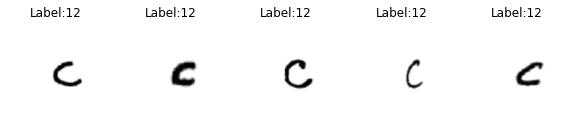

In [112]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    #sample_image = mnist.train.images[index].reshape(28, 28)
    #array = np.array(x_test_big[])
    sample_image= pics[index].reshape(224,224)
    plt.title("Label:" + str((labels[index])))
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

This piece of information is needed for training on non-MNIST data to process the data batch since other datasets do not have predefined next_batch functions.

In [113]:
#fashion_mnist.train.num_examples
#len(svhn_train['image'])
#np_svhn = tfds.as_numpy(svhn_train['image'])
#svhn_some = svhn_train.batch(128)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=100,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        fill_mode='nearest')

def next_batch(num, data, labels, pos_positions, intended_size_letters, where):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]
    labels_shuffle = np.asarray(labels_shuffle.reshape(len(labels_shuffle),))
    #insert this line for data work
    data_shuffle_non, labels_shuffle_non, data_shuffle_occlude, labels_shuffle_occlude = create_bigger_pics(224, 224, pos_positions, data_shuffle, intended_size_letters, labels_shuffle, where)
    
    #data_shuffle_non, labels_shuffle_non = create_bigger_pics(224, 224, pos_positions, data_shuffle, intended_size_letters, labels_shuffle, 0)
    #if data_distortion:
    #  iterator = datagen.flow(data_shuffle, labels_shuffle, batch_size=num)
    #  data_shuffle, labels_shuffle = iterator.next()
    #n_samples = 15
    #plt.figure(figsize=(n_samples * 2, 3))
    #for index in range(n_samples):
    #  plt.subplot(1, n_samples, index + 1)
    #  sample_image = data_shuffle[index].reshape(28, 28)
    #  plt.title("Label:" + str(labels_shuffle[index]))
    #  plt.imshow(sample_image, cmap="binary")
    #  plt.axis("off")
    #plt.show()
    return data_shuffle_non, labels_shuffle_non, data_shuffle_occlude, labels_shuffle_occlude

This code segment relabels the relevant categories.

In [130]:
letters_of_interest = (12,17,28,29)

In [131]:
#don't rerun this code unless data is read again
counter = 0
for letter in range(len(letters_of_interest)):
  y_test_new = np.where(y_test_new == letters_of_interest[letter], counter, y_test_new)
  y_train_new = np.where(y_train_new == letters_of_interest[letter], counter, y_train_new)
  y_validation_new = np.where(y_validation_new == letters_of_interest[letter], counter, y_validation_new)
  counter += 1

Make sure to override the translated data onto the relevant variables.

In [132]:
x_train = x_train_new
y_train = y_train_new
x_test = x_test_new
y_test = y_test_new
x_validation = x_validation_new
y_validation = y_validation_new

## Mount drive and train

If this did not happen yet, the drive needs to be mounted. 

In [117]:
%load_ext tensorboard
import datetime
from google.colab import drive
import os

drive.mount('/content/drive')
%cd '/content/drive/My Drive/CapsNets'
log_dir = "/content/drive/My Drive/CapsNets/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
os.makedirs(log_dir, exist_ok=True)
#%tensorboard --port=6008 --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CapsNets


How many stimuli are there for each letter?

In [118]:
print(len(y_test)//4)
print(len(y_train)//4)
print(len(y_validation)//4)

662
2938
73


In [119]:
#x_train = pictures_long
#y_train = y_own
#x_validation = pictures_long
#y_validation = y_own

If you want to load a different network, then you need to indicate the path here.

In [120]:
#checkpoint_path = "./my_capsule_network_3_pos"

In [121]:
#with tf.Session() as sess:
#    if tf.train.checkpoint_exists(checkpoint_path):
#        saver.restore(sess, checkpoint_path)
#        print("Restored older version")

Attention: here the training happens. And it is asked again whether the checkpoint is supposed to be restored and a new checkpoint path is set if you do not change it.

In [135]:
n_epochs = 1
batch_size = 30
#batch_size_inv = batch_size
restore_checkpoint = False

#n_iterations_per_epoch = mnist.train.num_examples // batch_size
#n_iterations_validation = mnist.validation.num_examples // batch_size
n_iterations_per_epoch = len(x_train) // (batch_size)
n_iterations_validation = len(x_validation) // (batch_size)

#n_iterations_per_epoch = len(new_array) // batch_size
#n_iterations_validation = len(new_validation) // batch_size
best_loss_val = np.infty
#this is the good network -> do not override or get rid of it
checkpoint_path = "./my_capsule_network"
#checkpoint_path = "./my_capsule_network_size"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
      init.run()
    #writer = tf.summary.FileWriter(["./graphs", sess.graph])
    writer = tf.summary.FileWriter(log_dir, sess.graph)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            #X_batch, y_batch = next_batch(batch_size, new_array.reshape(-1, 28, 28, 1), new_labels, 0)
            #X_batch, y_batch = next_batch(batch_size, mnist.train.images.reshape(-1, 28, 28, 1), mnist.train.labels, 1)
            #X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch, y_batch, _, _ = next_batch(batch_size, x_train.reshape(-1,28,28,1), y_train, pos_positions, intended_size_letters,0)
            #X_batch, y_batch = next_batch(batch_size, pictures_long.reshape(-1,28,28,1), y_own, pos_positions, intended_size_letters)
            # Run the training operation and measure the loss:
            
            #decoder_input_out, margin_loss_out, routing_weights_out = sess.run(
            #    [decoder_input, margin_loss, routing_weights],
            #    feed_dict={X: X_batch.reshape([-1, 224, 224, 1]),
            #               y: y_batch,
            #               mask_with_labels: True})
            #_, loss_train = sess.run(
            #    [training_op, loss],
            #    feed_dict={X: X_batch.reshape([-1, 224, 224, 1]),
            #              decoder_input_placeholder: np.array(decoder_input_out),
            #              routing_weights: routing_weights_out, 
            #              y: y_batch,
            #              margin_loss: margin_loss_out})
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 224, 224, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            #X_batch, y_batch = next_batch(batch_size, mnist.validation.images.reshape(-1, 28, 28, 1), mnist.validation.labels, 1)
            #X_batch, y_batch = mnist.validation.next_batch(batch_size)
            X_batch, y_batch, _, _ = next_batch(batch_size, x_validation.reshape(-1,28,28,1), y_validation, pos_positions, intended_size_letters_validation, 0)
            #X_batch, y_batch = next_batch(batch_size, new_validation.reshape(-1,28,28,1), new_validation_labels, 0)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 224, 224, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val


Epoch: 1  Val accuracy: 21.8519%  Loss: 0.569968 (improved)


This is how one picture would be run through the network.

In [136]:
X_batch, y_batch, _, _ = next_batch(1, x_train.reshape(-1,28,28,1), y_train, pos_positions, intended_size_letters,0 )

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  V1_activation, V2_activation, V4_activation, digit_activation, decoder_output_value, V4_inv, V2_inv, V1_inv = sess.run(
                [pool_v1, pool_v2, caps1_output, caps2_output, decoder_output, conv2_inv, conv_v2_inv, conv_v1_inv],
                feed_dict={X: X_batch.reshape([-1, 224, 224, 1]),
                           y: y_batch,
                           mask_with_labels: True})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


# Evaluation

Training is finished. Now let's evaluate the model on the test set.

In [ ]:
#this code is only used in case that we want to classify again images that were reconstructed from the network itself
#labels = [item for item in [0,1,2,3] for i in range(num)]
#decoder_reshape = decoder_output_value.reshape([num*4, 224, 224])
#y_test = np.array(labels)
#x_test = decoder_reshape

In [138]:
#pos_positions = pos_positions_test
#n_iterations_test = mnist.test.num_examples // batch_size
n_iterations_test = len(x_test) // batch_size

with tf.Session() as sess:
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    y_pred_out = np.array([])
    sample_labels_long = np.array([])

    for iteration in range(1, n_iterations_test + 1):
        #X_batch, y_batch = mnist.test.next_batch(batch_size)
        X_batch, y_batch, _, _ = next_batch(batch_size, x_test.reshape(-1,28,28,1), y_test, pos_positions, intended_size_letters_test, 0)
        
        #decoder_input_out = sess.run(
        #        [decoder_input],
        #        feed_dict={X: X_batch.reshape([-1, 224, 224, 1]),
        #                   y: y_batch})
        loss_test, acc_test, y_pred_value = sess.run(
                [loss, accuracy, y_pred],
                feed_dict={X: X_batch.reshape([-1, 224, 224, 1]),
                           y: y_batch})
        
        y_pred_out = np.append(y_pred_out, y_pred_value)
        sample_labels_long = np.append(sample_labels_long, y_batch)

        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 25.3409%  Loss: 0.554546


We reach a high accuracy on the test set.

# Predictions

In [139]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

Now let's make some predictions! We first fix a few images from the test set, then we start a session, restore the trained model, evaluate `caps2_output` to get the capsule network's output vectors, `decoder_output` to get the reconstructions, and `y_pred` to get the class predictions:

In [140]:
n_samples = 4
n_iterations = len(x_test)//n_samples
y_pred_out = np.array([])
sample_labels_long=np.array([])
sample_images_long=np.empty(shape = (0,224,224,1))
decoder_output_long = np.empty(shape = (0,224,224,1))

y_pred_out_occlude = np.array([])
sample_labels_long_occlude = np.array([])
sample_images_long_occlude=np.empty(shape = (0,224,224,1))
decoder_output_long_occlude = np.empty(shape = (0,224,224,1))

caps2_output_values=np.empty(shape = (0,1,4,16,1))

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  for iteration in range(0, n_iterations):
      sample_images, sample_labels, sample_images_occlude, sample_labels_occlude = create_bigger_pics(224, 224, pos_positions, x_test[iteration*n_samples:(iteration+1)*n_samples].reshape([-1,28,28,1]), intended_size_letters_test, y_test[iteration*n_samples:(iteration+1)*n_samples],2)  
      #sample_images, sample_labels = create_bigger_pics_occluded(224, 224, pos_positions, x_test[iteration*n_samples:(iteration+1)*n_samples].reshape([-1,28,28,1]), intended_size_letters_test, y_test[iteration*n_samples:(iteration+1)*n_samples],0)  
      #decoder_input_out = sess.run(
      #      [decoder_input],
      #      feed_dict={X: sample_images,
      #                 y: np.array([], dtype=np.int64)})
      caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

      caps2_output_value_occlude, decoder_output_value_occlude, y_pred_value_occlude = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images_occlude,
                       y: np.array([], dtype=np.int64)})
            
      y_pred_out = np.append(y_pred_out, y_pred_value)
      sample_labels_long = np.append(sample_labels_long, sample_labels)
      sample_images_long = np.append(sample_images_long, sample_images, axis= 0)
      decoder_output_long = np.append(decoder_output_long, np.reshape(decoder_output_value, (4,224,224,1)), axis= 0)
      caps2_output_values = np.append(caps2_output_values, caps2_output_value)
      

      y_pred_out_occlude = np.append(y_pred_out_occlude, y_pred_value_occlude)
      sample_labels_long_occlude = np.append(sample_labels_long_occlude, sample_labels_occlude)
      sample_images_long_occlude = np.append(sample_images_long_occlude, sample_images_occlude, axis= 0)
      decoder_output_long_occlude = np.append(decoder_output_long_occlude, np.reshape(decoder_output_value_occlude, (4,224,224,1)), axis= 0)

      #print((iteration+1)*n_samples)

INFO:tensorflow:Restoring parameters from ./my_capsule_network


## Predictions for own letters

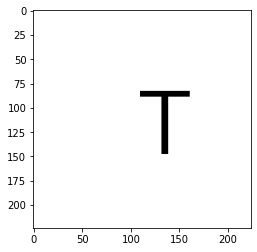

In [168]:
sample_images, sample_labels, _, _ = next_batch(n_samples, x_test.reshape([-1, 28, 28, 1]), np.array(y_test), pos_positions, intended_size_letters,0)

plt.imshow(sample_images[0].reshape(224,224))
plt.imshow(letter_array[3,:,:], cmap="binary")

In [169]:
intended_size_letters_test = [(48,48)]

In [170]:
pos_positions = [(100, 80)]

In [171]:
n_samples = 4

#sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])
#sample_images = mnist.test.images.reshape([-1, 28, 28, 1])
#sample_images = x_test[:n_samples].reshape([-1, 224, 224, 1])

#sample_images, sample_labels = next_batch(n_samples, x_test.reshape([-1, 28, 28, 1]), np.array(y_test), pos_positions, intended_size_letters_test, 0)

#sample_images = letter_array.reshape([-1,224,224,1])
#sample_labels = np.array(y_pics)

sample_images_non, sample_labels_non, sample_images_occlude, sample_labels_occlude = next_batch(n_samples, x_test.reshape([-1, 28, 28, 1]), np.array(y_test), pos_positions, intended_size_letters, 0)


with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    #decoder_input_out = sess.run(
    #        [decoder_input],
    #        feed_dict={X: sample_images,
    #                   y: np.array([], dtype=np.int64)})
    caps2_output_value, decoder_output_value, y_pred_value, V1_activation, V2_activation, V3_activation, V4_activation, V3_inv, V2_inv, V1_inv = sess.run(
            [caps2_output, decoder_output, y_pred, pool_v1, pool_v2, conv1, caps1_output, decoder_output_caps, conv_v2_inv, conv_v1_inv],
            feed_dict={X: sample_images_non,
                       y: np.array([], dtype=np.int64)})
  

INFO:tensorflow:Restoring parameters from ./my_capsule_network


In [172]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value_occ, y_pred_value, V1_activation, V2_activation, V4_activation, V2_inv, V1_inv = sess.run(
            [caps2_output, decoder_output, y_pred, pool_v1, pool_v2, caps1_output, conv_v2_inv, conv_v1_inv],
            feed_dict={X: decoder_output_value.reshape((-1,224,224,1)),
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


In [173]:
V3_activation.shape

(4, 20, 20, 256)

In [174]:
np.savetxt('V3_perc_caps.txt', V3_activation.reshape(4,102400))
np.savetxt('V2_perc_caps.txt', V2_activation.reshape(4,100352))
np.savetxt('V1_perc_caps.txt', V1_activation.reshape(4,200704))

np.savetxt('V3_inv_perc_caps.txt', V3_inv.reshape(4,93312))
np.savetxt('V2_inv_perc_caps.txt', V2_inv.reshape(4,200704))
np.savetxt('V1_inv_perc_caps.txt', decoder_output_value)

In [175]:
#np.savetxt('Caps2_output.txt', (caps2_output_value[0,0,:,:,0])) #, caps2_output_value[1,0,:,:,0], caps2_output_value[2,0,:,:,0], caps2_output_value[3,0,:,:,0])

np.savetxt('Caps2_output.txt', np.r_[caps2_output_value[0,0,:,:,0], caps2_output_value[1,0,:,:,0], caps2_output_value[2,0,:,:,0], caps2_output_value[3,0,:,:,0]])
print(open('Caps2_output.txt').read())

9.073360706679522991e-04 -3.902361989021301270e-01 -2.300254702568054199e-01 4.860203564167022705e-01 -1.113264635205268860e-01 1.768816113471984863e-01 4.255319386720657349e-02 -3.670188412070274353e-02 1.156590208411216736e-01 -1.752991974353790283e-01 -3.532794117927551270e-01 -8.621366322040557861e-02 1.520494222640991211e-01 -4.462907463312149048e-02 -3.448085784912109375e-01 4.066717922687530518e-01
-3.736878186464309692e-02 8.690985292196273804e-02 -2.280664071440696716e-02 9.077924303710460663e-03 -2.533843554556369781e-02 -6.771095842123031616e-02 2.785557694733142853e-02 4.048417136073112488e-02 -1.083348039537668228e-02 7.492854725569486618e-03 2.728385664522647858e-02 1.191771868616342545e-02 2.907920256257057190e-02 -6.618250906467437744e-02 -7.046372443437576294e-02 1.458346247673034668e-01
1.417238861322402954e-01 -5.051730573177337646e-02 -2.657468616962432861e-02 2.954480238258838654e-02 -4.531883448362350464e-02 7.198092341423034668e-02 5.426876246929168701e-02 -3.038

Note: we feed `y` with an empty array, but TensorFlow will not use it, as explained earlier.

In [176]:
!pip install researchpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
from PIL import ImageChops, Image
import math, operator
from matplotlib import pyplot
from skimage.metrics import structural_similarity as ssim
import cv2
import argparse
from astropy.table import QTable
from numpy import *
from scipy.spatial.distance import pdist, squareform
import pandas as pd
#from pandas import *
import researchpy as rp
import scipy.stats as stats
import os
import sys

In [178]:
def calculate_psnr(img1, img2, max_value=28*28):
    #Calculating peak signal-to-noise ratio (PSNR) between two images.
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
    mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    mse_error /= float(imageA.shape[0] * imageA.shape[1])
	
    # return the MSE. The lower the error, the more "similar" the two images are.
    return mse_error

def compare(imageA, imageB):
    # Calculate the MSE and SSIM
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    # Return the SSIM. The higher the value, the more "similar" the two images are.
    return s


#dcov, dvar,cent_dist_dcor to calculate distance correlation between two matrices https://en.wikipedia.org/wiki/Distance_correlation
def dcov(X, Y):
    #Computes the distance covariance between matrices X and Y.
    n = X.shape[0]
    XY = np.multiply(X, Y)
    cov = np.sqrt(XY.sum()) / n
    return cov

def dvar(X):
    #Computes the distance variance of a matrix X
    return np.sqrt(np.sum(X ** 2 / X.shape[0] ** 2))

def cent_dist(X):
    #Computes the pairwise euclidean distance between rows of X and centers
    #each cell of the distance matrix with row mean, column mean, and grand mean
    M = squareform(pdist(X))    # distance matrix
    rmean = M.mean(axis=1)
    cmean = M.mean(axis=0)
    gmean = rmean.mean()
    R = np.tile(rmean, (M.shape[0], 1)).transpose()
    C = np.tile(cmean, (M.shape[1], 1))
    G = np.tile(gmean, M.shape)
    CM = M - R - C + G
    return CM

def dcor(X, Y):
    #Computes the distance correlation between two matrices X and Y.
    #X and Y must have the same number of rows.
    #>>> X = np.matrix('1;2;3;4;5')
    #>>> Y = np.matrix('1;2;9;4;4')
    #>>> dcor(X, Y)
    #0.76267624241686649
    assert X.shape[0] == Y.shape[0]
    A = cent_dist(X)
    B = cent_dist(Y)
    dcov_AB = dcov(A, B)
    dvar_A = dvar(A)
    dvar_B = dvar(B)
    dcor = 0.0
    if dvar_A > 0.0 and dvar_B > 0.0:
        dcor = dcov_AB / np.sqrt(dvar_A * dvar_B)
    return dcor

from skimage.metrics import structural_similarity

And now let's plot the images and their labels, followed by the corresponding reconstructions and predictions:

In [179]:
reconstruction = decoder_output_value.reshape([-1,224,224])
reconstruction_occlude = decoder_output_value_occ.reshape([-1,224,224])

In [180]:
corr_recon_occ = np.zeros(len(reconstruction))

for index in range(len(reconstruction)):
  corr_recon_occ[index] = dcor(reconstruction[index], reconstruction_occlude[index])
  euclid_dist = linalg.norm(reconstruction[index] - reconstruction_occlude[index])

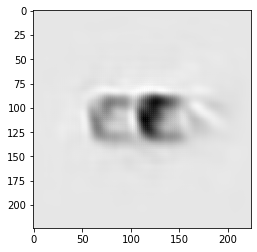

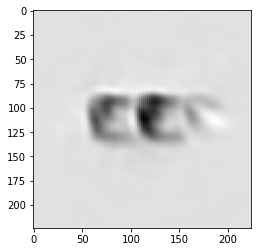

In [181]:
plt.imshow(reconstruction[3].reshape(224,224), cmap="binary")
plt.show()
plt.imshow(reconstruction_occlude[3].reshape(224,224), cmap="binary")

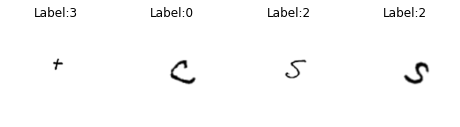

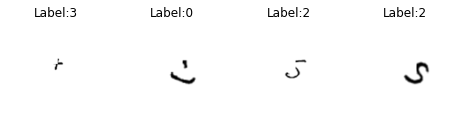

In [182]:
plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images_non[index].reshape(224,224), cmap="binary")
    #plt.title("Label:" + str(mnist.test.labels[index]))
    plt.title("Label:" + str(sample_labels_non[index]))
    plt.axis("off")

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images_occlude[index].reshape(224,224), cmap="binary")
    #plt.title("Label:" + str(mnist.test.labels[index]))
    plt.title("Label:" + str(sample_labels_non[index]))
    plt.axis("off")

plt.show()

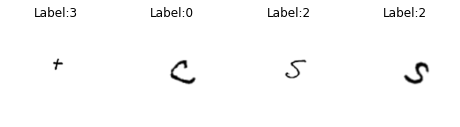

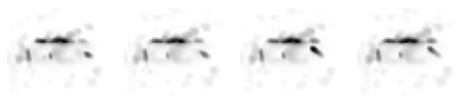

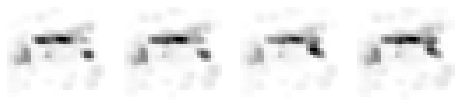

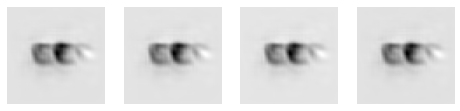

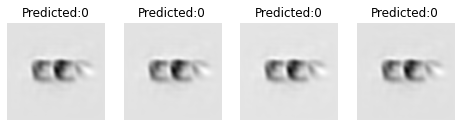

<Figure size 432x288 with 0 Axes>

In [183]:
average_V1 = np.average(V1_activation, 3)

from google.colab import files
#sample_images = sample_images_occlude.reshape(-1, 224, 224)
sample_images = sample_images_non.reshape(-1, 224, 224)
#reconstructions = reconstruction_occlude.reshape([-1, 224, 224])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index].reshape(224,224), cmap="binary")
    #plt.title("Label:" + str(mnist.test.labels[index]))
    plt.title("Label:" + str(sample_labels_non[index]))
    plt.axis("off")

#plt.show()
plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(average_V1[index], cmap="binary")
    #plt.title("Label:" + str(mnist.test.labels[index]))
    #plt.title("Label:" + str(sample_labels[index]))
    plt.axis("off")

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(np.average(V2_activation,3)[index], cmap="binary")
    #plt.title("Label:" + str(mnist.test.labels[index]))
    #plt.title("Label:" + str(sample_labels[index]))
    plt.axis("off")

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(np.average(V2_inv,3)[index], cmap="binary")
    #plt.title("Label:" + str(mnist.test.labels[index]))
    #plt.title("Label:" + str(sample_labels[index]))
    plt.axis("off")

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(np.average(V1_inv,3)[index], cmap="binary")
    #plt.title("Label:" + str(mnist.test.labels[index]))
    #plt.title("Label:" + str(sample_labels[index]))
    plt.axis("off")

#plt.figure(figsize=(n_samples * 2, 3))
#for index in range(n_samples):
#    plt.subplot(1, n_samples, index + 1)
#    plt.title("Predicted:" + str(y_pred_value[index]))
#    plt.imshow(reconstructions[index], cmap="binary")
#    plt.axis("off")

fig = plt.figure()
#fig.savefig(f"{images_dir}/test_size.png")    
plt.show()
#plt.savefig(f"{images_dir}/test_size.png")
#plt.savefig("test_size.png")
#fig = plt.figure()
#fig.write_image("image.png")

In [184]:
len(intended_size_letters_validation) + len(intended_size_letters) + len(intended_size_letters_test) 

40

The predictions are all correct, and the reconstructions look great. Hurray!

In [185]:
print(y_pred_out)
len(y_pred_out)
#len(sample_labels)

[0. 0. 0. ... 0. 0. 0.]


2648

Let's print in a confusion matrix the true labels against the predicted labels.

In [189]:
#cm = confusion_matrix(y_true=mnist.test.labels[:n_samples], y_pred=y_pred_value)
cm = confusion_matrix(y_true=sample_labels[:n_samples], y_pred=y_pred_value)
#cm = confusion_matrix(y_true=labels, y_pred=y_pred_value)

In [190]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [191]:
a = 0
h = 0
s= 0
t= 0
for item in y_test:
  if item == 0:
    a = a+1
  elif item == 1:
    h = h+1
  elif item == 2:
    s = s+1
  elif item == 3:
    t = t+1
print(a, h, s, t)

662 662 662 662


In [192]:
plt.style.use('ggplot')

Confusion matrix, without normalization
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


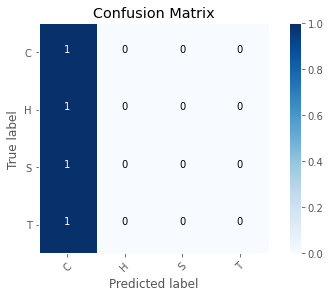

In [194]:
#cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
cm_plot_labels = ['C','H','S','T']
matplotlib.pyplot.grid(visible=False)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [196]:
from scipy import signal
cor = signal.correlate2d (sample_images_long[0,:,:,0], np.reshape(caps2_output_values, (-1,1,4,16,1))[0,0,:,:,0])

# Reconstruction and classification of occluded images

In [197]:
def unison_shuffled_copies(a, b, c, d, e):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p], e[p]

sample_labels_long, decoder_output_long, sample_labels_long_occlude, decoder_output_long_occlude, sample_images_long = unison_shuffled_copies(sample_labels_long, decoder_output_long, sample_labels_long_occlude, decoder_output_long_occlude, sample_images_long)

In [202]:
half = int(len(sample_images_long)/2)

In [203]:
from sklearn import svm
# lower right corner: 120:150, 140:170
# upper right corner: 80:110,  140:170
# lower left corner:  120:150, 100:130
# upper left corner:  80:110,  100,130
X_svm = sample_images_long[:half, 80:110,  140:170, 0].reshape(-1,900)
y_svm = sample_labels_long[:half]
clf = svm.SVC()
clf.fit(X_svm, y_svm)

SVC()

In [204]:
predict_data = decoder_output_long_occlude[half:,80:110, 140:170, 0].reshape(-1,900)
prediction_svm = clf.predict(predict_data)

In [205]:
prediction_svm

array([0., 2., 0., ..., 0., 0., 0.])

In [206]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

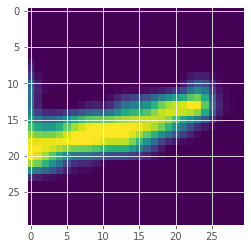

In [207]:
plt.imshow(sample_images_long[150, 80:110, 140:170,0])

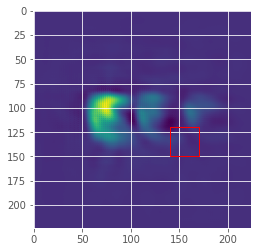

In [208]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(decoder_output_long_occlude[1900,:,:,0])

# Create a Rectangle patch
rect = patches.Rectangle((140, 120), 30, 30, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

Classify the reconstructions of the occluded images:

In [209]:
y_pred_out_recon = np.array([])
sample_labels_long_recon = np.array([])
sample_images_long_recon =np.empty(shape = (0,224,224,1))
decoder_output_long_recon = np.empty(shape = (0,224,224,1))

n_iterations = int(len(x_test)//n_samples)

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  for iteration in range(0, n_iterations):
    sample_images = decoder_output_long_occlude[iteration*n_samples:(iteration+1)*n_samples].reshape([-1,224,224,1])
    caps2_output_value_recon, decoder_output_value_recon, y_pred_value_recon = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images.reshape(-1, 224, 224, 1),
                       y: np.array([], dtype=np.int64)})
    
    y_pred_out_recon = np.append(y_pred_out_recon, y_pred_value_recon)
    decoder_output_long_recon = np.append(decoder_output_long_recon, np.reshape(decoder_output_value_recon, (4,224,224,1)), axis= 0)


INFO:tensorflow:Restoring parameters from ./my_capsule_network


# Evaluate Correlations

In [210]:
print(len(X_batch))
print(len(y_batch))
print(y_batch)

30
30
[3 3 1 0 1 3 3 0 0 1 1 2 2 3 1 0 2 1 0 0 0 0 0 3 2 0 2 0 3 0]


This calculates the average measures of similarity for the reconstructions.

In [211]:
mse_values = np.zeros(shape = len(decoder_output_value))
rmse_values = np.zeros(shape = len(decoder_output_value))
psnrs = np.zeros(shape = len(decoder_output_value))
correlations = np.zeros(shape = len(decoder_output_value))
euclid_distances = np.zeros(shape = len(decoder_output_value))
ssim_values = np.zeros(shape = len(decoder_output_value))

for frame in range(len(decoder_output_value)):
  image1 = sample_images_long[frame,:,:,0]
  image2 = np.reshape(decoder_output_long[frame,:], (224,224))
  gray1 = image1
  gray2 = image2
  # Check for same size and ratio and report accordingly
  ho, wo = image1.shape
  hc, wc = image2.shape
  ratio_orig = ho/wo
  ratio_comp = hc/wc
  dim = (wc, hc)
  if round(ratio_orig, 2) != round(ratio_comp, 2):
    print("\nImages not of the same dimension. Check input.")
    exit()
  # Resize first image if the second image is smaller
  elif ho > hc and wo > wc:
    print("\nResizing original image for analysis...")
    gray1 = cv2.resize(gray1, dim)
  elif ho < hc and wo < wc:
    print("\nCompressed image has a larger dimension than the original. Check input.")
    exit()
  if round(ratio_orig, 2) == round(ratio_comp, 2):
   #calculate all values, see functions above
   #values are measurements for noise ratio of picture or for similarity between pictures
   #always 2 pictures needed to make comparisons
   mse_value = mse(gray1, gray2)
   rmse_value = math.sqrt(mse(gray1, gray2))
   ssim_value = structural_similarity(gray1, gray2)
   #snr = np.mean(10 * np.log10(np.array(image1, dtype=np.float32)**2//(np.array(image1, dtype=np.float32) - np.array(image2, dtype=np.float32)) ** 2))
   psnr = calculate_psnr(image1,image2)
   correlation = dcor(image1, image2)
   euclid_dist = linalg.norm(image1-image2)
   #print("MSE:", mse_value)
   #print("SSIM:", ssim_value)
   #put all in a long list of items to make calculations on these
   list_item = [mse_value,psnr, correlation, euclid_dist]
   mse_values[frame] = mse_value
   rmse_values[frame] = rmse_value
   ssim_values[frame] = ssim_value
   #snrs[frame, frame_2] = snr
   psnrs[frame] = psnr
   correlations[frame] = correlation
   euclid_distances[frame] = euclid_dist
   #data.append(list_item)

Values for the thesis:

In [212]:
print(mean(correlations)) #first order correlations between presented letters and reconstruction from network
print(mean(mse_values))
print(mean(rmse_values))
print(mean(ssim_values))
print(mean(euclid_distances))
print(mean(psnrs))

0.8176912320132457
376.06361691801703
18.809828803025244
0.026883601006960686
4213.401651877654
32.67081175637162


Sort the long list by letter:

In [213]:
list_0 = np.empty(shape = (0,224,224,1))
list_1 = np.empty(shape = (0,224,224,1))
list_2 = np.empty(shape = (0,224,224,1))
list_3 = np.empty(shape = (0,224,224,1))

list_0_de = np.empty(shape = (0,224,224,1))
list_1_de = np.empty(shape = (0,224,224,1))
list_2_de = np.empty(shape = (0,224,224,1))
list_3_de = np.empty(shape = (0,224,224,1))

for item in range(len(sample_labels_long)):
  if sample_labels_long[item] == 0:
    list_0 = np.append(list_0, [sample_images_long[item]], axis = 0)
    list_0_de = np.append(list_0_de, [decoder_output_long[item]], axis = 0)
    #list_0 = , decoder_output_long[item]], axis = 0)
  elif sample_labels_long[item] == 1:
    list_1 = np.append(list_1, [sample_images_long[item]], axis = 0)
    list_1_de = np.append(list_1_de, [decoder_output_long[item]], axis = 0)
    #list_1 = np.append(list_1, [sample_images_long[item], decoder_output_long[item]], axis = 0)
  elif sample_labels_long[item] ==2:
    list_2 = np.append(list_2, [sample_images_long[item]], axis = 0)
    list_2_de = np.append(list_2_de, [decoder_output_long[item]], axis = 0)
  elif sample_labels_long[item] == 3:
    list_3 = np.append(list_3, [sample_images_long[item]], axis = 0)
    list_3_de = np.append(list_3_de, [decoder_output_long[item]], axis = 0)
  else:
    print(f"something weird happend - {sample_labels_long[item]}")

list_0 = list(zip(list_0,list_0_de))
list_1 = list(zip(list_1, list_1_de))
list_2 = list(zip(list_2, list_2_de))
list_3 = list(zip(list_3, list_3_de))

In [214]:
def second_order_corr(sample_images_long):
  #mse_values = np.array([])
  #ssim_values = np.zeros(shape = len(sample_images_long))
  #psnrs = np.array([])
  correlations = np.array([])
  #euclid_distances = np.array([])

  for item in range(len(sample_images_long)):
    for item_2 in range(len(sample_images_long)):
        image1 = sample_images_long[item,:,:,0]
        image2 = sample_images_long[item_2,:,:,0]
        gray1 = image1
        gray2 = image2
        # Check for same size and ratio and report accordingly
        #ho, wo = image1.shape
        #hc, wc = image2.shape
        #ratio_orig = ho/wo
        #ratio_comp = hc/wc
        #dim = (wc, hc)
        #if round(ratio_orig, 2) != round(ratio_comp, 2):
        #  print("\nImages not of the same dimension. Check input.")
        #  exit()
        # Resize first image if the second image is smaller
        #elif ho > hc and wo > wc:
        #  print("\nResizing original image for analysis...")
        #  gray1 = cv2.resize(gray1, dim)
        #elif ho < hc and wo < wc:
        #  print("\nCompressed image has a larger dimension than the original. Check input.")
        #  exit()
        #if round(ratio_orig, 2) == round(ratio_comp, 2):
         #calculate all values, see functions above
         #values are measurements for noise ratio of picture or for similarity between pictures
         #always 2 pictures needed to make comparisons
         #mse_value = mse(gray1, gray2)
         #ssim_value = compare(gray1, gray2)
         #snr = np.mean(10 * np.log10(np.array(image1, dtype=np.float32)**2//(np.array(image1, dtype=np.float32) - np.array(image2, dtype=np.float32)) ** 2))
         #psnr = calculate_psnr(image1,image2)
        correlation = dcor(image1, image2)
         #euclid_dist = linalg.norm(image1-image2)
         #print("MSE:", mse_value)
         #print("SSIM:", ssim_value)
         #put all in a long list of items to make calculations on these
         #list_item = [mse_value,psnr, correlation, euclid_dist]
         #mse_values = np.append(mse_values, mse_value)
         #ssim_values[frame, frame_2] = ssim_value
         #snrs[frame, frame_2] = snr
         #psnrs = np.append(psnrs, psnr)
        correlations = np.append(correlations, correlation)
         #euclid_distances = np.append(euclid_distances,euclid_dist)
         #data.append(list_item)
    #print(item)
  return correlations

Calculate second order correlations for the 100 first stimuli.

In [215]:
correlations_im = second_order_corr(sample_images_long[:100])
correlations_de = second_order_corr(decoder_output_long[:100])

print(correlations_im)

[1.         0.64832827 0.87623743 ... 0.65676843 0.78757063 1.        ]


In [216]:
np.corrcoef(correlations_im, correlations_de)

array([[1.        , 0.27530296],
       [0.27530296, 1.        ]])

First level calculations for each letter separately.

In [217]:
def first_level_corr(list_0):
  mse_values = np.zeros(shape = len(list_0))
  rmse_values = np.zeros(shape = len(list_0))
  psnrs = np.zeros(shape = len(list_0))
  correlations = np.zeros(shape = len(list_0))
  euclid_distances = np.zeros(shape = len(list_0))
  ssim_values = np.zeros(shape = len(list_0))

  for frame in range(len(list_0)):
    image1 = list_0[frame][0][:,:,0]
    image2 = list_0[frame][1][:,:,0]
    gray1 = image1
    gray2 = image2
    # Check for same size and ratio and report accordingly
    ho, wo = image1.shape
    hc, wc = image2.shape
    ratio_orig = ho/wo
    ratio_comp = hc/wc
    dim = (wc, hc)
    if round(ratio_orig, 2) != round(ratio_comp, 2):
      print("\nImages not of the same dimension. Check input.")
      exit()
    # Resize first image if the second image is smaller
    elif ho > hc and wo > wc:
      print("\nResizing original image for analysis...")
      gray1 = cv2.resize(gray1, dim)
    elif ho < hc and wo < wc:
      print("\nCompressed image has a larger dimension than the original. Check input.")
      exit()
    if round(ratio_orig, 2) == round(ratio_comp, 2):
     #calculate all values, see functions above
     #values are measurements for noise ratio of picture or for similarity between pictures
     #always 2 pictures needed to make comparisons
     mse_value = mse(gray1, gray2)
     rmse_value = math.sqrt(mse(gray1, gray2))
     ssim_value = compare(gray1, gray2)
     #snr = np.mean(10 * np.log10(np.array(image1, dtype=np.float32)**2//(np.array(image1, dtype=np.float32) - np.array(image2, dtype=np.float32)) ** 2))
     psnr = calculate_psnr(image1,image2)
     correlation = dcor(image1, image2)
     euclid_dist = linalg.norm(image1-image2)
     #print("MSE:", mse_value)
     #print("SSIM:", ssim_value)
     #put all in a long list of items to make calculations on these
     list_item = [mse_value,psnr, correlation, euclid_dist]
     mse_values[frame] = mse_value
     rmse_values[frame] = rmse_value
     ssim_values[frame] = ssim_value
     #snrs[frame, frame_2] = snr
     psnrs[frame] = psnr
     correlations[frame] = correlation
     euclid_distances[frame] = euclid_dist
     #data.append(list_item)
  return correlations, psnrs, ssim_values, euclid_distances, mse_values, rmse_values

In [218]:
correlations_0, psnrs_0, ssim_0, euclid_distances_0, mse_values_0, rmse_0 = first_level_corr(list_0)
correlations_1, psnrs_1, ssim_1, euclid_distances_1, mse_values_1, rmse_1 = first_level_corr(list_1)
correlations_2, psnrs_2, ssim_2, euclid_distances_2, mse_values_2, rmse_2 = first_level_corr(list_2)
correlations_3, psnrs_3, ssim_3, euclid_distances_3, mse_values_3, rmse_3 = first_level_corr(list_3)

In [219]:
print(mean(correlations_0), mean(correlations_1), mean(correlations_2), mean(correlations_3))
print(mean(ssim_0), mean(ssim_1), mean(ssim_2), mean(ssim_3))
print(mean(rmse_0), mean(rmse_1), mean(rmse_2), mean(rmse_3))
#print(mean(mse_values_0), mean(mse_values_1), mean(mse_values_2), mean(mse_values_3))
print(mean(euclid_distances_0), mean(euclid_distances_1), mean(euclid_distances_2), mean(euclid_distances_3))
print(mean(psnrs_0), mean(psnrs_1), mean(psnrs_2), mean(psnrs_3))

0.8361556386913789 0.8695755574681648 0.8448267740069905 0.8421805799395825
0.030000223304538137 0.027538697357532956 0.029077022425381897 0.028360764116523114
19.86956980714271 21.30557846504541 21.365888927571405 18.682296799449706
4450.783636799967 4772.449576170173 4785.9591197759955 4184.834483076733
32.2226210505164 31.676411820363565 31.66797579133573 32.746850882005454


In [220]:
print(y_test)
len(sample_labels_long)
len(y_pred_out)

[0. 0. 0. ... 3. 3. 3.]


2648

# Interpreting the Output Vectors / Reconstructions

Let's tweak the output vectors to see what their pose parameters represent.

First, let's check the shape of the `cap2_output_value` NumPy array:

In [221]:
caps2_output_value.shape

(4, 1, 4, 16, 1)

Let's create a function that will tweak each of the 16 pose parameters (dimensions) in all output vectors. Each tweaked output vector will be identical to the original output vector, except that one of its pose parameters will be incremented by a value varying from -0.5 to 0.5. By default there will be 11 steps (-0.5, -0.4, ..., +0.4, +0.5). This function will return an array of shape (_tweaked pose parameters_=16, _steps_=11, _batch size_=5, 1, 10, 16, 1):

In [222]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

Let's compute all the tweaked output vectors and reshape the result to (_parameters_×_steps_×_instances_, 1, 10, 16, 1) so we can feed the array to the decoder:

In [238]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

Here we read the file that predicts the capsule activations from fMRI activations of higher level areas.

In [224]:
caps_input = np.loadtxt('fMRI_Caps2_pred.txt')
#caps_input_im.shape
caps_input_new = caps_input.reshape(4,1,4,16,1)

Caps predictions for imagery trials.

In [225]:
caps_input_im = np.loadtxt('fMRI_im_Caps2_pred.txt')
caps_input_im = caps_input_im.reshape(128,1,4,16,1)

In [226]:
caps_input = np.loadtxt('Caps2_output.txt')

For the variable caps_input_im, range(32) has to be given, for caps_input, a range of (1) has to be given. This difference is due to the largely differing amount of number of trials in the perception and the imagery condition.

In [242]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    #decoder_input_out = sess.run(
    #        decoder_input,
    #        feed_dict={caps2_output: tweaked_vectors_reshaped,
    #                   mask_with_labels: True,
    #                   y: tweak_labels})
    decoder_output_value, V2_act_inv, V3_act_inv = sess.run(
            [decoder_output, conv_v2_inv, decoder_output_caps],
            feed_dict={caps2_output: caps_input_im,
                       #routing_weights: new_array,
                       mask_with_labels: True,
                       y: [item for item in [0,1,2,3] for i in range(32)]})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


After running the information through the network, reconstructions for V3, V2, V1 can be extracted and are saved in files.

In [228]:
np.savetxt('V2_im_caps.txt', V2_act_inv.reshape((128,200704)))

In [229]:
np.savetxt('V3_im_caps.txt', V3_act_inv.reshape((128, 93312)))

In [230]:
np.savetxt('Reconstruction_im.txt', decoder_output_value)

Additionally, the reconstructions can be printed out here for visual inspection.

In [231]:
num = 32

labels = [item for item in [0,1,2,3] for i in range(num)]
decoder_reshape = decoder_output_value.reshape([num*4, 224, 224])
for item in range(len(decoder_reshape)):
  plt.figure()
  #plt.subplot(1, n_samples, index + 1)
  plt.title("Label:" + str(labels[item]))
  plt.imshow(decoder_reshape[item], cmap="binary")
  plt.axis("off")
  fig = plt.figure()
  #fig.savefig(f"{images_dir}/test_size.png")    
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

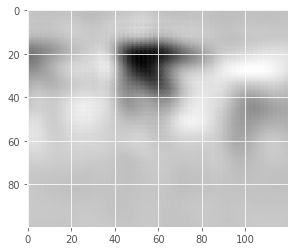

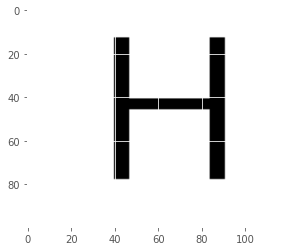

<Figure size 432x288 with 0 Axes>

In [232]:
plt.imshow(decoder_reshape[50][70:170, 65:185], cmap="binary")
plt.show()
plt.imshow(letter_array[1][70:170, 70:190], cmap="binary")
#plt.axis("off")
fig = plt.figure()
#fig.savefig(f"{images_dir}/test_size.png")    
plt.show()
#decoder_reshape[item], letter_array[letter].reshape(224,224)

Similarity measures between reconstructions and the relevant stimuli are calculated.

11.71875 % highest correlation with actual stimulus.
21.875 % c highest correlation for c trials
3.125 % h highest correlation for h trials
0.0 % s highest correlation for s trials
21.875 % t highest correlation for t trials


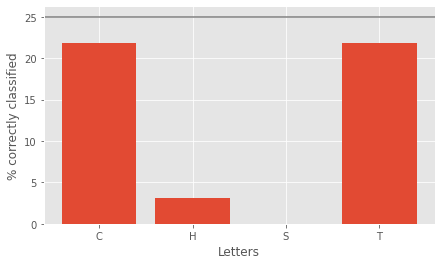

In [233]:
from tensorflow.python.ops.math_ops import argmin_v2
index_c = 0
index_h = 0
index_s = 0
index_t = 0

correlation = np.zeros((len(decoder_reshape),len(letter_array)))
for item in range(len(decoder_reshape)):
  for letter in range(len(letter_array)):
    #mse_value = mse(gray1, gray2)
    #ssim_value = compare(gray1, gray2)
    #snr = np.mean(10 * np.log10(np.array(image1, dtype=np.float32)**2//(np.array(image1, dtype=np.float32) - np.array(image2, dtype=np.float32)) ** 2))
    #psnr = calculate_psnr(image1,image2)
    #correlation = dcor(image1, image2)
    #euclid_dist = linalg.norm(image1-image2)
    
    #[80:145, 90:160]   #old: [70:170, 65:195]
    #[70:135, 95:165]   #[70:170, 70:200]
    #max of these is best
    correlation[item][letter] = dcor(decoder_reshape[item], letter_array[letter].reshape(224,224))
    #correlation[item][letter] = calculate_psnr(decoder_reshape[item][70:170, 65:195], letter_array[letter].reshape(224,224)[70:170, 70:200])
    #correlation[item][letter] = compare(decoder_reshape[item][70:170, 65:195], letter_array[letter].reshape(224,224)[70:170, 70:200])
    
    #min of these best
    #correlation[item][letter] = linalg.norm(decoder_reshape[item][70:170, 65:185]-letter_array[letter].reshape(224,224)[70:170, 70:190])
    #correlation[item][letter] = math.sqrt(mse(decoder_reshape[item][70:170, 65:195],letter_array[letter].reshape(224,224)[70:170, 70:200]))
    
  if item < num and argmax(correlation[item]) == 0:
    index_c += 1
  elif num <= item < num*2 and argmax(correlation[item]) == 1:
      index_h += 1
  elif num*2 <= item < num*3 and argmax(correlation[item]) == 2:
      index_s += 1
  elif num*3 <= item < num*4 and argmax(correlation[item]) == 3:
      index_t += 1
print((index_c+index_h+index_s+index_t)/len(decoder_reshape)*100, '% highest correlation with actual stimulus.')
print(index_c/num*100, '% c highest correlation for c trials')
print(index_h/num*100, '% h highest correlation for h trials')
print(index_s/num*100, '% s highest correlation for s trials')
print(index_t/num*100, '% t highest correlation for t trials')

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (7,4))
ax.bar([0,1,2,3], [index_c/num*100, index_h/num*100, index_s/num*100, index_t/num*100])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['C', 'H', 'S', 'T'])
ax.axhline(y = 25, color = 'tab:gray', linestyle = '-')
ax.set_xlabel('Letters')
ax.set_ylabel('% correctly classified')
plt.show()

In [234]:
mse_value = mse(image1, image2)
#ssim_value = compare(gray1, gray2)
#snr = np.mean(10 * np.log10(np.array(image1, dtype=np.float32)**2//(np.array(image1, dtype=np.float32) - np.array(image2, dtype=np.float32)) ** 2))
psnr = calculate_psnr(image1,image2)
correlation = dcor(image1, image2)
euclid_dist = linalg.norm(image1-image2)

This is the likelihood of a specific amount of matches.

In [235]:
1- stats.binom.cdf(41, 128, 0.25)

0.02876067451829334

Now let's feed these tweaked output vectors to the decoder and get the reconstructions it produces:

In [245]:
tweak_labels = np.tile(y_test[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


In [246]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 224, 224])

Lastly, let's plot all the reconstructions, for the first 3 output dimensions, for each tweaking step (column) and each digit (row):

Tweaking output dimension #0


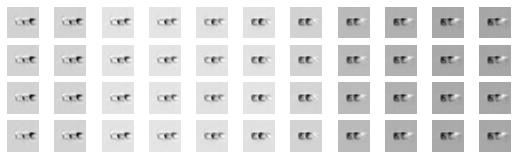

Tweaking output dimension #1


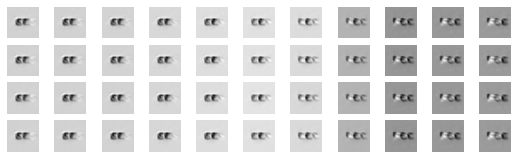

Tweaking output dimension #2


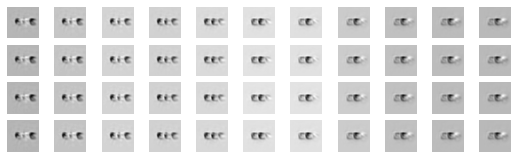

Tweaking output dimension #3


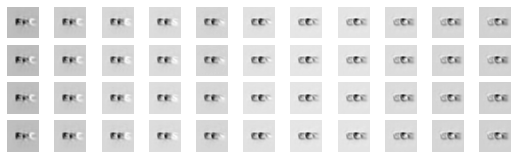

Tweaking output dimension #4


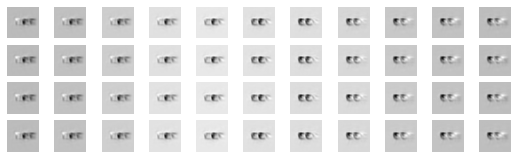

Tweaking output dimension #5


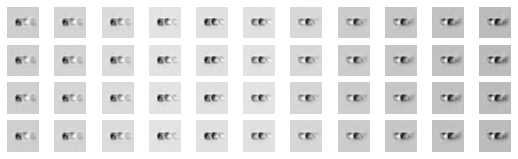

In [247]:
for dim in range(6):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()

# Conclusion

I tried to make the code in this notebook as flat and linear as possible, to make it easier to follow, but of course in practice you would want to wrap the code in nice reusable functions and classes. For example, you could try implementing your own `PrimaryCapsuleLayer`, and `DenseRoutingCapsuleLayer` classes, with parameters for the number of capsules, the number of routing iterations, whether to use a dynamic loop or a static loop, and so on. For an example a modular implementation of Capsule Networks based on TensorFlow, take a look at the [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow) project.

That's all for today, I hope you enjoyed this notebook!